# Synthetic-to-Real Generalization for Chessboard Square Classification

This notebook presents the training and evaluation pipeline for a chessboard square
classification model, with a focus on **synthetic-to-real generalization**.

The task is to classify each square of a chessboard image into one of multiple classes
corresponding to chess pieces (including empty squares), using **only a single static image**
as input. The model is trained primarily on **synthetic chessboard images** generated from
a simulated environment (blender) and evaluated on **real-world chessboard images**.

## Objectives
The main objectives of this notebook are:
- Train a deep learning classifier using **synthetic data only**
- Evaluate **zero-shot generalization** to real chessboard images.
- Perform **fine-tuning** using a small amount of real data.
- Train a **combined model** using both synthetic and real images.
- Analyze the effect of domain shift between synthetic and real data.

## Approach
The pipeline includes:
- Data loading and preprocessing for both synthetic and real datasets.
- Square-level classification using a convolutional neural network.
- Separate preprocessing strategies for synthetic and real domains.
- Evaluation of per-square accuracy and full-board reconstruction.

The trained model outputs per-square predictions, which can be assembled into a full
board state representation (FEN notation).

This notebook contains all steps required to reproduce the training and evaluation results.

In [ ]:
%pip -q install opencv-python albumentations python-chess cairosvg scikit-learn tqdm
%pip -q install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu121

In [2]:
import os, re, glob, random, math, gc
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import torchvision

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

import chess
import chess.svg
import cairosvg

cv2.ocl.setUseOpenCL(False)
cv2.setNumThreads(0)

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(42)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

def gpu_cleanup():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

gpu_cleanup()

/home/sameachm/venvs/dl/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


DEVICE: cuda


## Global config

## FEN parsing + label mapping


In [3]:
DATA_ROOT = "./chess_data" #DATA ROOT
# Board / square sizes
MAX_BOARD_SIZE = 512 
SQUARE_SIZE = 96         
INSET_RATIO = 0.10      
SECOND_INSET = 0.06      
BOARD_GUARD = 0.02
# Preprocess strategy
USE_CHESSBOARD_WARP = False  # depends on corner-based warp
WARP_QUALITY_TH = 0.14

print("DATA_ROOT:", DATA_ROOT)

DATA_ROOT: ./chess_data


In [4]:
PIECE_TO_CLASS = {
    "P": "wP", "N": "wN", "B": "wB", "R": "wR", "Q": "wQ", "K": "wK",
    "p": "bP", "n": "bN", "b": "bB", "r": "bR", "q": "bQ", "k": "bK",
}
CLASSES = ["empty", "wP","wN","wB","wR","wQ","wK","bP","bN","bB","bR","bQ","bK"]
CLASS_TO_IDX = {c:i for i,c in enumerate(CLASSES)}
IDX_TO_CLASS = {i:c for c,i in CLASS_TO_IDX.items()}

def fen_to_grid(fen: str) -> np.ndarray:
    placement = fen.split(" ")[0]
    rows = placement.split("/")
    assert len(rows) == 8, f"Bad FEN rows: {fen}"
    grid = np.zeros((8,8), dtype=np.int64)
    for r, row in enumerate(rows):
        c = 0
        for ch in row:
            if ch.isdigit():
                c += int(ch)
            else:
                cls = PIECE_TO_CLASS.get(ch, None)
                if cls is None:
                    raise ValueError(f"Unknown piece char '{ch}' in fen={fen}")
                grid[r, c] = CLASS_TO_IDX[cls]
                c += 1
        assert c == 8, f"Bad row width in fen={fen} row={row}"
    return grid

def has_neighbor_piece(grid: np.ndarray, r: int, c: int) -> bool:
    """True if any 8-neighbor contains a piece (non-empty)."""
    for dr in (-1,0,1):
        for dc in (-1,0,1):
            if dr == 0 and dc == 0:
                continue
            rr = r + dr
            cc = c + dc
            if 0 <= rr < 8 and 0 <= cc < 8:
                if int(grid[rr, cc]) != CLASS_TO_IDX["empty"]:
                    return True
    return False

def compute_square_weights_for_df(df: pd.DataFrame,
                                 hard_empty_boost: float = 3.0) -> np.ndarray:
    """Returns per-square sampling weights for a dataframe of boards.
    Rule:
      - If the center square is empty but has a neighboring piece -> weight *= hard_empty_boost
    """
    n_boards = len(df)
    w = np.ones((n_boards, 64), dtype=np.float32)
    for i in range(n_boards):
        grid = fen_to_grid(df.iloc[i]["fen"])
        for r in range(8):
            for c in range(8):
                y = int(grid[r, c])
                if y == CLASS_TO_IDX["empty"] and has_neighbor_piece(grid, r, c):
                    w[i, r*8 + c] *= float(hard_empty_boost)
    return w.reshape(-1)

def compute_class_weights_from_df(df: pd.DataFrame,
                                 power: float = 0.5,
                                 empty_downweight: float = 0.5,
                                 min_w: float = 0.2,
                                 max_w: float = 10.0) -> torch.Tensor:
    """Compute class weights for CrossEntropyLoss.
    - Uses counts over ALL 64 squares in df.
    - Inverse-frequency with exponent `power` (sqrt-inv by default).
    - Additionally down-weights the 'empty' class to prevent empty-collapse.
    """
    counts = np.zeros(len(CLASSES), dtype=np.int64)
    for _, row in df.iterrows():
        g = fen_to_grid(row["fen"]).reshape(-1)
        for y in g:
            counts[int(y)] += 1

    counts = np.maximum(counts, 1)
    freq = counts / counts.sum()
    inv = (1.0 / freq) ** float(power)

    # normalize so mean weight ~ 1
    inv = inv / inv.mean()

    # extra empty down-weight
    inv[CLASS_TO_IDX["empty"]] *= float(empty_downweight)

    inv = np.clip(inv, float(min_w), float(max_w)).astype(np.float32)
    return torch.tensor(inv, dtype=torch.float32)

## Dataset indexing utilities


In [5]:
def find_csv_in_folder(folder: str) -> Optional[str]:
    cands = sorted(glob.glob(os.path.join(folder, "*.csv")))
    if len(cands) == 0:
        cands = sorted(glob.glob(os.path.join(folder, "**", "*.csv"), recursive=True))
    return cands[0] if len(cands) else None

def infer_images_folder(game_folder: str) -> Optional[str]:
    for name in ["images", "tagged_images"]:
        p = os.path.join(game_folder, name)
        if os.path.isdir(p):
            return p
    for p in glob.glob(os.path.join(game_folder, "**", "images"), recursive=True):
        if os.path.isdir(p):
            return p
    for p in glob.glob(os.path.join(game_folder, "**", "tagged_images"), recursive=True):
        if os.path.isdir(p):
            return p
    return None

def find_image_for_frame(images_folder: str, frame_id: int) -> Optional[str]:
    patterns = [
        f"*{frame_id}.*",
        f"*{frame_id:06d}.*",
        f"*{frame_id:05d}.*",
        f"*{frame_id:04d}.*",
        f"*{frame_id:03d}.*",
    ]
    exts = ["png", "jpg", "jpeg", "bmp", "webp"]
    for pat in patterns:
        for ext in exts:
            c = glob.glob(os.path.join(images_folder, pat.replace(".*", f".{ext}")))
            if c:
                return sorted(c)[0]

    files = []
    for ext in exts:
        files.extend(glob.glob(os.path.join(images_folder, f"*.{ext}")))
    if not files:
        return None

    best = None
    best_dist = 10**18
    for fp in files:
        nums = re.findall(r"\d+", os.path.basename(fp))
        if not nums:
            continue
        n = int(nums[-1])
        dist = abs(n - frame_id)
        if dist < best_dist:
            best_dist = dist
            best = fp
            if dist == 0:
                break
    if best is not None:
        nums = re.findall(r"\d+", os.path.basename(best))
        if nums and int(nums[-1]) == frame_id:
            return best
    return None

def build_samples_index(data_root: str) -> pd.DataFrame:
    game_folders = []
    for sub in ["highres_main/high_res_data", "synthetic_from_pgn", "real"]:
        p = os.path.join(data_root, sub)
        if os.path.isdir(p):
            game_folders.extend(sorted([os.path.join(p, d) for d in os.listdir(p) if os.path.isdir(os.path.join(p, d))]))

    rows = []
    for gf in tqdm(game_folders, desc="Scanning games"):
        csv_path = find_csv_in_folder(gf)
        images_folder = infer_images_folder(gf)
        if csv_path is None or images_folder is None:
            continue

        try:
            df = pd.read_csv(csv_path)
        except Exception as e:
            print("Failed reading", csv_path, e)
            continue

        if "fen" not in df.columns:
            continue

        frame_col = None
        for cand in ["from_frame", "frame", "frame_id", "image_id", "to_frame"]:
            if cand in df.columns:
                frame_col = cand
                break
        if frame_col is None:
            continue

        is_real = ("real" + os.sep) in (gf + os.sep) or (os.path.basename(images_folder) == "tagged_images")
        domain = "real" if is_real else "synthetic"

        for _, rr in df.iterrows():
            fen = str(rr["fen"])
            try:
                frame_id = int(rr[frame_col])
            except Exception:
                continue
            img_path = find_image_for_frame(images_folder, frame_id)
            if img_path is None:
                continue
            rows.append({
                "domain": domain,
                "game_folder": gf,
                "images_folder": images_folder,
                "csv_path": csv_path,
                "frame_id": frame_id,
                "image_path": img_path,
                "fen": fen,
            })

    out = pd.DataFrame(rows).drop_duplicates(subset=["image_path"]).reset_index(drop=True)
    return out

samples_df = build_samples_index(DATA_ROOT)
print("Total labeled images:", len(samples_df))
print(samples_df["domain"].value_counts())
display(samples_df.head())

Scanning games:   0%|          | 0/78 [00:00<?, ?it/s]

Total labeled images: 10242
domain
synthetic    9725
real          517
Name: count, dtype: int64


,domain,game_folder,images_folder,csv_path,frame_id,image_path,fen
0,synthetic,./chess_data/highres_main/high_res_data/game_0000,./chess_data/highres_main/high_res_data/game_0...,./chess_data/highres_main/high_res_data/game_0...,0,./chess_data/highres_main/high_res_data/game_0...,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR
1,synthetic,./chess_data/highres_main/high_res_data/game_0000,./chess_data/highres_main/high_res_data/game_0...,./chess_data/highres_main/high_res_data/game_0...,1,./chess_data/highres_main/high_res_data/game_0...,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR
2,synthetic,./chess_data/highres_main/high_res_data/game_0000,./chess_data/highres_main/high_res_data/game_0...,./chess_data/highres_main/high_res_data/game_0...,2,./chess_data/highres_main/high_res_data/game_0...,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR
3,synthetic,./chess_data/highres_main/high_res_data/game_0000,./chess_data/highres_main/high_res_data/game_0...,./chess_data/highres_main/high_res_data/game_0...,3,./chess_data/highres_main/high_res_data/game_0...,rnbqkbnr/pppppppp/8/8/8/4P3/PPPP1PPP/RNBQKBNR
4,synthetic,./chess_data/highres_main/high_res_data/game_0000,./chess_data/highres_main/high_res_data/game_0...,./chess_data/highres_main/high_res_data/game_0...,4,./chess_data/highres_main/high_res_data/game_0...,rnbqkbnr/pppppppp/8/8/8/4P3/PPPP1PPP/RNBQKBNR


In [6]:
def preprocess_board_domain(img_bgr: np.ndarray, domain: str, out_size: int = 512) -> Tuple[np.ndarray, Dict]:
    """
    domain: "synthetic" or "real"
    - real: use preprocess_board_real
    - synthetic: use preprocess_board but with gentler params to avoid over-cropping
    """
    if domain == "real":
        return preprocess_board_real(img_bgr, out_size=out_size, fallback=True)

    # synthetic: same pipeline but gentler tightening
    return preprocess_board(img_bgr, out_size=out_size, roi_min_area=0.001, domain="synthetic")

## Board preprocessing + square slicing


In [7]:
def expand_quad(quad: np.ndarray, scale: float = 1.06) -> np.ndarray:
    """Expand quad around its centroid (helps avoid cutting borders)."""
    quad = quad.astype(np.float32)
    c = quad.mean(axis=0, keepdims=True)
    return (c + (quad - c) * scale).astype(np.float32)

In [8]:
def trim_frame_by_checkerboard_safe(board_bgr, max_shrink_frac=0.06, stride=4, min_side=220):
    """
    Find the best inner crop that maximizes checkerboard alternation, but only
    allow a small shrink so we don't lose real squares.
    """
    h, w = board_bgr.shape[:2]
    s = min(h, w)
    y0 = (h - s)//2
    x0 = (w - s)//2
    base = board_bgr[y0:y0+s, x0:x0+s]

    gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)

    max_shrink = int(s * max_shrink_frac)
    best = (0, 0, s)
    best_score = -1e9

    for shrink in range(0, max_shrink + 1, max(1, stride)):
        ss = s - 2*shrink
        if ss < min_side:
            break

        g8 = _grid_means(gray, shrink, shrink, ss)
        if g8 is None:
            continue

        sc = _alternation_score(g8)
        # tiny bias to prefer larger crops (prevents over-shrinking when scores are similar)
        sc = sc - 0.02 * (shrink / max(1, max_shrink))

        if sc > best_score:
            best_score = sc
            best = (shrink, shrink, ss)

    x, y, ss = best
    cropped = base[y:y+ss, x:x+ss].copy()
    return cropped, float(best_score)

def trim_to_grid_by_edge_energy(board_bgr, max_trim_frac=0.20, smooth=31):
    """
    Trim brown frame by finding the high-edge-energy region (the actual grid).
    max_trim_frac: maximum fraction we are allowed to trim from each side.
    """
    h, w = board_bgr.shape[:2]
    s = min(h, w)
    y0 = (h - s)//2
    x0 = (w - s)//2
    base = board_bgr[y0:y0+s, x0:x0+s]

    gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)

    # edges
    v = np.median(gray)
    lo = int(max(0, 0.66*v))
    hi = int(min(255, 1.33*v))
    edges = cv2.Canny(gray, lo, hi)

    # edge energy profiles
    rowE = edges.mean(axis=1).astype(np.float32)
    colE = edges.mean(axis=0).astype(np.float32)

    # smooth profiles so pieces dont dominate
    def smooth1d(x, k):
        k = int(k)
        if k % 2 == 0: k += 1
        if k < 3: return x
        return cv2.GaussianBlur(x.reshape(-1,1), (1,k), 0).reshape(-1)

    rowS = smooth1d(rowE, smooth)
    colS = smooth1d(colE, smooth)

    # we expect low energy in frame, high energy in grid.
    # choose thresholds relative to max
    rth = 0.35 * rowS.max()
    cth = 0.35 * colS.max()

    r_idx = np.where(rowS >= rth)[0]
    c_idx = np.where(colS >= cth)[0]
    if len(r_idx) < 10 or len(c_idx) < 10:
        # fallback: dont trim
        return base, {"trim_method": "edge_energy_fail"}

    top = int(r_idx[0])
    bot = int(r_idx[-1])
    left = int(c_idx[0])
    right = int(c_idx[-1])

    # limit trimming so we never cut too much
    max_trim = int(max_trim_frac * s)
    top = min(max_trim, top)
    left = min(max_trim, left)
    bot = max(s - max_trim, bot)
    right = max(s - max_trim, right)

    cropped = base[top:bot+1, left:right+1].copy()
    return cropped, {"trim_method": "edge_energy", "top": top, "bot": bot, "left": left, "right": right}

def symmetric_trim_to_grid(board_bgr, max_trim_frac=0.25, smooth=31, thresh=0.30):
    """
    Find grid extent using edge-energy, then crop symetrically around center
    so we dont keep only one-side brown margin.
    Returns (cropped_square_bgr, dbg)
    """
    h, w = board_bgr.shape[:2]
    s = min(h, w)
    y0 = (h - s)//2
    x0 = (w - s)//2
    base = board_bgr[y0:y0+s, x0:x0+s]

    gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)

    v = np.median(gray)
    lo = int(max(0, 0.66*v))
    hi = int(min(255, 1.33*v))
    edges = cv2.Canny(gray, lo, hi)

    rowE = edges.mean(axis=1).astype(np.float32)
    colE = edges.mean(axis=0).astype(np.float32)

    def smooth1d(x, k):
        k = int(k)
        if k % 2 == 0: k += 1
        if k < 3: return x
        return cv2.GaussianBlur(x.reshape(-1,1), (1,k), 0).reshape(-1)

    rowS = smooth1d(rowE, smooth)
    colS = smooth1d(colE, smooth)

    rth = thresh * float(rowS.max() + 1e-6)
    cth = thresh * float(colS.max() + 1e-6)

    r_idx = np.where(rowS >= rth)[0]
    c_idx = np.where(colS >= cth)[0]
    if len(r_idx) < 10 or len(c_idx) < 10:
        return base, {"trim_method": "symmetric_fail"}

    top, bot = int(r_idx[0]), int(r_idx[-1])
    left, right = int(c_idx[0]), int(c_idx[-1])

    # center of detected grid box
    cy = 0.5 * (top + bot)
    cx = 0.5 * (left + right)

    half_w = max(cx - left, right - cx)
    half_h = max(cy - top, bot - cy)
    half = int(np.ceil(max(half_w, half_h)))

    # allow trimming up to max_trim_frac
    max_trim = int(max_trim_frac * s)
    half = min(half, (s//2) - 1)                 
    half = max(half, (s//2) - max_trim)      

    cx_i = int(round(cx))
    cy_i = int(round(cy))

    x0c = max(0, cx_i - half)
    x1c = min(s, cx_i + half)
    y0c = max(0, cy_i - half)
    y1c = min(s, cy_i + half)

    # make it exactly square by adjusting if needed
    side = min(x1c - x0c, y1c - y0c)
    x0c = int(np.clip(cx_i - side//2, 0, s - side))
    y0c = int(np.clip(cy_i - side//2, 0, s - side))
    x1c = x0c + side
    y1c = y0c + side

    cropped = base[y0c:y1c, x0c:x1c].copy()
    dbg = {
        "trim_method": "symmetric_edge_energy",
        "top": top, "bot": bot, "left": left, "right": right,
        "cx": float(cx), "cy": float(cy),
        "crop": (x0c, y0c, x1c, y1c),
        "side": int(side),
        "thresh": float(thresh)
    }
    return cropped, dbg
    
def crop_inner_board(board_bgr, inner_frac=0.90):
    """
    Deterministically crop the inner board area.
    inner_frac=0.90 keeps 90% of the side → removes ~5% from each side.
    """
    h, w = board_bgr.shape[:2]
    s = min(h, w)
    margin = int(round((1.0 - inner_frac) * s / 2.0))
    if margin <= 0:
        return board_bgr
    return board_bgr[margin:s-margin, margin:s-margin]

In [9]:
from PIL import Image

def find_board_roi_by_bg(img_bgr: np.ndarray, pad: int = 24, min_area_frac: float = 0.001) -> Tuple[Optional[Tuple[int,int,int,int]], Dict]:
    dbg = {}
    h, w = img_bgr.shape[:2]
    k = max(8, int(min(h, w) * 0.03))

    top = img_bgr[:k, :, :]
    bottom = img_bgr[-k:, :, :]
    left = img_bgr[:, :k, :]
    right = img_bgr[:, -k:, :]
    
    border_pixels = np.concatenate([
        top.reshape(-1,3), bottom.reshape(-1,3), left.reshape(-1,3), right.reshape(-1,3)
    ], axis=0)
    bg = np.median(border_pixels, axis=0).astype(np.uint8)
    dbg["bg_color_bgr"] = bg

    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB).astype(np.int16)
    bg_lab = cv2.cvtColor(bg.reshape(1,1,3), cv2.COLOR_BGR2LAB).astype(np.int16).reshape(3)

    diff = (lab - bg_lab).astype(np.float32)
    dist = np.sqrt(np.sum(diff * diff, axis=2))
    dist = np.nan_to_num(dist, nan=0.0, posinf=0.0, neginf=0.0)

    dist_norm = cv2.normalize(dist, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    _, mask = cv2.threshold(dist_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((5,5), np.uint8), iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((9,9), np.uint8), iterations=2)
    dbg["mask_clean"] = mask

    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return None, dbg

    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    c = cnts[0]
    area = cv2.contourArea(c)
    dbg["area"] = float(area)

    if area < min_area_frac * (h*w):
        return None, dbg

    x, y, bw, bh = cv2.boundingRect(c)
    x0 = max(0, x - pad); y0 = max(0, y - pad)
    x1 = min(w, x + bw + pad); y1 = min(h, y + bh + pad)
    return (x0, y0, x1, y1), dbg

def final_border_trim(board_bgr, frac=0.0):
    if frac <= 0:
        h, w = board_bgr.shape[:2]
        s = min(h, w)
        return board_bgr[(h-s)//2:(h+s)//2, (w-s)//2:(w+s)//2]

    h, w = board_bgr.shape[:2]
    s = min(h, w)
    m = int(round(s * frac))
    if m <= 0 or (s - 2*m) < 64:
        ss = min(h, w)
        return board_bgr[(h-ss)//2:(h+ss)//2, (w-ss)//2:(w+ss)//2]

    ss = min(h, w)
    sq = board_bgr[(h-ss)//2:(h+ss)//2, (w-ss)//2:(w+ss)//2]

    s2 = ss
    return sq[m:s2-m, m:s2-m]

def align_board_to_grid(img, out_size=512):
    if img is None:
        raise ValueError("align_board_to_grid: got None image")
    h, w = img.shape[:2]
    s = min(h, w)
    y0 = (h - s) // 2
    x0 = (w - s) // 2
    img = img[y0:y0+s, x0:x0+s]
    if img.shape[0] == 0 or img.shape[1] == 0:
        raise ValueError(f"align_board_to_grid: empty crop from original shape {(h,w)}")
    img = cv2.resize(img, (out_size, out_size), interpolation=cv2.INTER_AREA)
    return img

def order_quad_points(pts):
    pts = np.array(pts, dtype=np.float32)
    s = pts.sum(axis=1)
    d = np.diff(pts, axis=1).reshape(-1)
    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]
    tr = pts[np.argmin(d)]
    bl = pts[np.argmax(d)]
    return np.stack([tl, tr, br, bl], axis=0)

def detect_board_quad(bgr):
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)

    v = np.median(gray)
    lower = int(max(0, 0.66*v))
    upper = int(min(255, 1.33*v))
    edges = cv2.Canny(gray, lower, upper)
    edges = cv2.dilate(edges, np.ones((3,3), np.uint8), iterations=1)

    cnts, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return None

    H, W = gray.shape
    img_area = H * W
    best, best_score = None, -1.0

    for c in sorted(cnts, key=cv2.contourArea, reverse=True)[:25]:
        area = cv2.contourArea(c)
        if area < img_area * 0.002:
            continue

        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02*peri, True)

        if len(approx) == 4:
            quad = approx.reshape(4,2).astype(np.float32)
        else:
            rect = cv2.minAreaRect(c)
            quad = cv2.boxPoints(rect).astype(np.float32)

        quad = order_quad_points(quad)

        def dist(a,b): return float(np.linalg.norm(a-b))
        w1 = dist(quad[0], quad[1]); w2 = dist(quad[3], quad[2])
        h1 = dist(quad[0], quad[3]); h2 = dist(quad[1], quad[2])
        ww = (w1+w2)/2; hh = (h1+h2)/2
        if min(ww,hh) < 40:
            continue

        squareness = min(ww,hh)/max(ww,hh)
        score = area * squareness
        if score > best_score:
            best_score = score
            best = quad

    return best

def _alternation_score(gray_8x8):
    g = gray_8x8.astype(np.float32)
    g = (g - g.mean()) / (g.std() + 1e-6)
    rr, cc = np.indices((8,8))
    pattern = ((rr + cc) % 2) * 2 - 1
    return float(abs(np.mean(g * pattern)))

def _grid_means(gray, x0, y0, s):
    crop = gray[y0:y0+s, x0:x0+s]
    ss = (s // 8) * 8
    if ss < 64:
        return None
    crop = crop[:ss, :ss]
    block = ss // 8
    return crop.reshape(8, block, 8, block).mean(axis=(1,3))

def refine_board_crop_by_checkerboard(board_bgr, search_frac=0.22, stride=6):
    h, w = board_bgr.shape[:2]
    s = min(h, w)
    cx0 = (w - s)//2
    cy0 = (h - s)//2
    base = board_bgr[cy0:cy0+s, cx0:cx0+s]

    gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)

    max_shrink = int(s * search_frac)
    best = (0, 0, s)
    best_score = -1.0

    for shrink in range(0, max_shrink+1, max(2, stride)):
        ss = s - 2*shrink
        if ss < 160:
            break
        x0 = shrink
        y0 = shrink
        g8 = _grid_means(gray, x0, y0, ss)
        if g8 is None:
            continue
        sc = _alternation_score(g8)
        if sc > best_score:
            best_score = sc
            best = (x0, y0, ss)

    x0, y0, ss = best
    cropped = base[y0:y0+ss, x0:x0+ss].copy()
    return cropped, best_score

def refine_twostep(warped_bgr, inner_crop_frac=0.04, search_frac=0.22, stride=6):
    a_crop, a_score = refine_board_crop_by_checkerboard(warped_bgr, search_frac=search_frac, stride=stride)
    h, w = a_crop.shape[:2]
    s = min(h, w)
    m = int(round(s * inner_crop_frac))
    inner = a_crop[m:s-m, m:s-m] if (m*2 < s-64) else a_crop
    b_crop, b_score = refine_board_crop_by_checkerboard(inner, search_frac=search_frac*0.6, stride=stride)
    return a_crop, a_score, b_crop, b_score

def warp_board_two_stage(bgr, quad, max_board_size=MAX_BOARD_SIZE, domain="real"):
    quad = order_quad_points(quad)

    if domain == "synthetic":
        quad2 = expand_quad(quad, scale=1.12)  # try 1.05–1.12
        def dist(a,b): return float(np.linalg.norm(a-b))
        w1 = dist(quad2[0], quad2[1]); w2 = dist(quad2[3], quad2[2])
        h1 = dist(quad2[0], quad2[3]); h2 = dist(quad2[1], quad2[2])
        side = int(max(96, round((w1+w2+h1+h2)/4.0)))

        dst = np.array([[0,0],[side-1,0],[side-1,side-1],[0,side-1]], dtype=np.float32)
        M = cv2.getPerspectiveTransform(quad2, dst)
        warped = cv2.warpPerspective(bgr, M, (side, side), flags=cv2.INTER_CUBIC)

        sq = align_board_to_grid(warped, out_size=max_board_size)
        sq_crop, tdbg = symmetric_trim_to_grid(
            sq,
            max_trim_frac=0.30,
            smooth=31,
            thresh=0.28           
        )
        
        sq = align_board_to_grid(sq_crop, out_size=max_board_size)
        sq = crop_inner_board(sq, inner_frac=0.90)   # try 0.92 / 0.88 if needed
        sq = align_board_to_grid(sq, out_size=max_board_size)
        
        return sq

    def dist(a,b): return float(np.linalg.norm(a-b))
    w1 = dist(quad[0], quad[1]); w2 = dist(quad[3], quad[2])
    h1 = dist(quad[0], quad[3]); h2 = dist(quad[1], quad[2])
    side = int(max(96, round((w1+w2+h1+h2)/4.0)))

    dst = np.array([[0,0],[side-1,0],[side-1,side-1],[0,side-1]], dtype=np.float32)
    M = cv2.getPerspectiveTransform(quad.astype(np.float32), dst)
    warped = cv2.warpPerspective(bgr, M, (side, side), flags=cv2.INTER_CUBIC)

    refined = refine_twostep(warped, inner_crop_frac=0.039, search_frac=0.22, stride=6)[2]
    refined = align_board_to_grid(refined, out_size=max_board_size)
    refined = final_border_trim(refined, frac=0.0125)
    return refined


def preprocess_board(img_bgr: np.ndarray,
                     out_size: int = 512,
                     roi_min_area: float = 0.001,
                     domain: str = "real") -> Tuple[np.ndarray, Dict]:
    dbg = {"domain": domain}

    # Larger pad for synthetic because board is tiny inside large background
    pad = 28 if domain != "synthetic" else 120
    roi, roi_dbg = find_board_roi_by_bg(img_bgr, pad=pad, min_area_frac=roi_min_area)
    dbg.update({f"roi_{k}": v for k, v in roi_dbg.items()})
    dbg["roi"] = roi
    dbg["roi_pad_used"] = pad

    if roi is None:
        crop = img_bgr
        dbg["roi_used"] = False
    else:
        x0, y0, x1, y1 = roi
        crop = img_bgr[y0:y1, x0:x1].copy()
        dbg["roi_used"] = True

    quad = detect_board_quad(crop)
    dbg["quad"] = quad

    # if we found a quad: warp using the domain-aware warp
    if quad is not None:
        board = warp_board_two_stage(crop, quad, max_board_size=out_size, domain=domain)
        dbg["method"] = "quad_warp"
        return board, dbg

    # If no quad: just square-center-crop + resize
    board = align_board_to_grid(crop, out_size=out_size)
    board = final_border_trim(board, frac=0.0)
    dbg["method"] = "centercrop_resize"
    return board, dbg

def crop_square_from_board(board_bgr, r, c,
                           inset_ratio=INSET_RATIO,
                           second_inset=SECOND_INSET,
                           out_size=SQUARE_SIZE,
                           board_guard=BOARD_GUARD):
    S = board_bgr.shape[0]
    guard = int(round(S * board_guard))

    U0, U1 = guard, S - guard
    U = U1 - U0
    if U < 64:
        U0, U1 = 0, S
        U = S

    sq = U / 8.0

    x0 = int(round(U0 + c * sq))
    x1 = int(round(U0 + (c + 1) * sq))
    y0 = int(round(U0 + r * sq))
    y1 = int(round(U0 + (r + 1) * sq))

    dx = int(round((x1 - x0) * inset_ratio))
    dy = int(round((y1 - y0) * inset_ratio))
    x0i, x1i = x0 + dx, x1 - dx
    y0i, y1i = y0 + dy, y1 - dy

    x0i = max(0, min(S - 2, x0i))
    y0i = max(0, min(S - 2, y0i))
    x1i = max(x0i + 1, min(S - 1, x1i))
    y1i = max(y0i + 1, min(S - 1, y1i))

    patch = board_bgr[y0i:y1i, x0i:x1i]

    ph, pw = patch.shape[:2]
    m = int(round(min(ph, pw) * second_inset))
    if m > 0 and (ph - 2*m) > 8 and (pw - 2*m) > 8:
        patch = patch[m:ph - m, m:pw - m]

    ph, pw = patch.shape[:2]
    interp = cv2.INTER_CUBIC if out_size > max(ph, pw) else cv2.INTER_AREA
    patch = cv2.resize(patch, (out_size, out_size), interpolation=interp)
    return patch

def crop_context_square_from_board(board_bgr, r, c, k: float = 1.6, out_size: int = SQUARE_SIZE, board_guard: float = BOARD_GUARD):
    """Context crop around a target square.
    - Crops a *larger* region centered on (r,c) with side ~= k * square_size.
    - Resizes to out_size x out_size.
    - Label remains the *center* square (r,c).
    """
    if isinstance(board_bgr, Image.Image):
        board_bgr = cv2.cvtColor(np.array(board_bgr), cv2.COLOR_RGB2BGR)
        
    S = board_bgr.shape[0]
    guard = int(round(S * board_guard))
    U0, U1 = guard, S - guard
    U = U1 - U0
    if U < 64:
        U0, U1 = 0, S
        U = S

    sq = U / 8.0

    # Square box in board coords (within guarded board)
    x0 = U0 + c * sq
    x1 = U0 + (c + 1) * sq
    y0 = U0 + r * sq
    y1 = U0 + (r + 1) * sq

    cx = 0.5 * (x0 + x1)
    cy = 0.5 * (y0 + y1)

    side = float(k) * float(sq)
    half = 0.5 * side
    
    # distances to board edges
    left_room   = cx - U0
    right_room  = U1 - cx
    top_room    = cy - U0
    bottom_room = U1 - cy
    
    # asymmetric limits: allow more context inward, less outward
    half_x = min(half, left_room, right_room)
    half_y = min(half, top_room, bottom_room)
    
    # allow a small slack so we dont clamp too aggressively near edges
    SLACK_SQ = 0.2
    slack = SLACK_SQ * sq
    
    max_half = min(cx - U0, U1 - cx, cy - U0, U1 - cy) + slack
    half = min(half, max_half)

    xa = int(round(cx - half))
    xb = int(round(cx + half))
    ya = int(round(cy - half))
    yb = int(round(cy + half))

    # clip
    xa = max(0, min(S - 2, xa))
    ya = max(0, min(S - 2, ya))
    xb = max(xa + 1, min(S - 1, xb))
    yb = max(ya + 1, min(S - 1, yb))

    patch = board_bgr[ya:yb, xa:xb]
    ph, pw = patch.shape[:2]
    interp = cv2.INTER_CUBIC if out_size > max(ph, pw) else cv2.INTER_AREA
    patch = cv2.resize(patch, (out_size, out_size), interpolation=interp)
    return patch

def draw_grid(board_bgr: np.ndarray) -> np.ndarray:
    out = board_bgr.copy()
    S = out.shape[0]
    for i in range(9):
        x = int(round(i * S / 8))
        cv2.line(out, (x, 0), (x, S-1), (0,255,0), 1)
        cv2.line(out, (0, x), (S-1, x), (0,255,0), 1)
    return out

def show_grid_debug(img_path: str, out_size: int = 512):
    img = cv2.imread(img_path)
    assert img is not None, f"Failed to read {img_path}"
    warped, dbg = preprocess_board(img, out_size=out_size)
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); ax[0].set_title("Original"); ax[0].axis("off")
    ax[1].imshow(cv2.cvtColor(draw_grid(warped), cv2.COLOR_BGR2RGB)); ax[1].set_title(f"Warped ({dbg.get('method')})"); ax[1].axis("off")
    plt.show()
    return dbg

# REAL preprocessing
from sklearn.cluster import KMeans
# Uses line masks + Hough + clustering to estimate the 9x9 grid lines and warp to a square board.
def normalize_line(rho, theta):
    if rho < 0:
        rho = -rho
        theta = (theta + np.pi) % np.pi
    return float(rho), float(theta)

def extract_grid_masks(gray):
    g = cv2.GaussianBlur(gray, (5,5), 0)

    bw = cv2.adaptiveThreshold(
        g, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        21, 5
    )

    H, W = bw.shape

    close_k = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    bw2 = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, close_k, iterations=1)

    h_len = max(25, W // 14)
    v_len = max(25, H // 14)

    h_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (h_len, 1))
    v_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, v_len))

    # Extract horizontal
    h_mask = cv2.erode(bw2, h_kernel, iterations=1)
    h_mask = cv2.dilate(h_mask, h_kernel, iterations=2)

    # Extract vertical
    v_mask = cv2.erode(bw2, v_kernel, iterations=1)
    v_mask = cv2.dilate(v_mask, v_kernel, iterations=2)

    return bw2, h_mask, v_mask

def x_at_y(line, y):
    """For line x*cos(t)+y*sin(t)=rho, compute x at given y."""
    rho, t = line
    c, s = math.cos(t), math.sin(t)
    if abs(c) < 1e-9:
        return None
    return (rho - y*s) / c

def y_at_x(line, x):
    """For line x*cos(t)+y*sin(t)=rho, compute y at given x."""
    rho, t = line
    c, s = math.cos(t), math.sin(t)
    if abs(s) < 1e-9:
        return None
    return (rho - x*c) / s

def sort_vertical_lines_left_to_right(v_lines, img_h):
    ymid = img_h / 2.0
    scored = []
    for line in v_lines:
        xv = x_at_y(line, ymid)
        if xv is not None and np.isfinite(xv):
            scored.append((xv, line))
    scored.sort(key=lambda z: z[0])
    return [l for _, l in scored]

    xmid = img_w / 2.0
    scored = []
    for line in h_lines:
        yh = y_at_x(line, xmid)
        if yh is not None and np.isfinite(yh):
            scored.append((yh, line))
    scored.sort(key=lambda z: z[0])
    return [l for _, l in scored]

def hough_mask_lines(mask, is_horizontal):
    linesP = cv2.HoughLinesP(
        mask,
        rho=1,
        theta=np.pi/180,
        threshold=50,        
        minLineLength=40,  
        maxLineGap=30 
    )

    if linesP is None:
        return np.zeros((0,2), dtype=np.float32)

    out = []
    for x1,y1,x2,y2 in linesP[:,0]:
        dx = x2-x1
        dy = y2-y1
        ang = abs(math.degrees(math.atan2(dy, dx)))

        if is_horizontal:
            # near 0 degrees
            if ang > 10 and ang < 170:
                continue
            theta = np.pi/2
        else:
            # near 90 degrees
            if abs(ang - 90) > 10:
                continue
            theta = 0

        rho = x1*math.cos(theta) + y1*math.sin(theta)
        out.append(normalize_line(rho, theta))

    return np.array(out, dtype=np.float32)

def cluster_to_9_lines(lines):
    """
    Cluster by rho into 9 centers (KMeans), then choose representative theta per cluster.
    """
    if len(lines) < 20:
        raise RuntimeError(f"Too few candidate lines for clustering: {len(lines)}")

    L = np.array([normalize_line(r,t) for r,t in lines], dtype=np.float32)
    rhos = L[:,0].reshape(-1,1)

    km = KMeans(n_clusters=9, n_init="auto", random_state=0).fit(rhos)
    labels = km.labels_

    reps = []
    for k in range(9):
        group = L[labels == k]
        # use median rho, and average theta
        rho_k = float(np.median(group[:,0]))
        theta_k = float(np.mean(group[:,1]))
        reps.append((rho_k, theta_k))

    reps.sort(key=lambda x: x[0])
    return reps

def intersect(l1, l2):
    rho1, th1 = l1
    rho2, th2 = l2
    A = np.array([[math.cos(th1), math.sin(th1)],
                  [math.cos(th2), math.sin(th2)]], dtype=np.float64)
    b = np.array([rho1, rho2], dtype=np.float64)
    det = np.linalg.det(A)
    if abs(det) < 1e-10:
        return None
    x, y = np.linalg.solve(A, b)
    if not (np.isfinite(x) and np.isfinite(y)):
        return None
    return np.array([x,y], dtype=np.float64)

def _fit_homography_from_9x9_lines(gray: np.ndarray, board_px: int = 512):
    """Return (H_px, debug_dict) mapping image->board pixels, or (None, dbg) if fails."""
    dbg = {}
    Himg, Wimg = gray.shape[:2]
    bw, h_mask, v_mask = extract_grid_masks(gray)

    # Candidate lines from masks
    h_candidates = hough_mask_lines(h_mask, is_horizontal=True)
    v_candidates = hough_mask_lines(v_mask, is_horizontal=False)
    dbg["n_h_candidates"] = len(h_candidates)
    dbg["n_v_candidates"] = len(v_candidates)

    if len(h_candidates) < 9 or len(v_candidates) < 9:
        return None, dbg

    # Cluster into exactly 9 lines each
    h9 = cluster_to_9_lines(h_candidates)
    v9 = cluster_to_9_lines(v_candidates)
    if len(h9) != 9 or len(v9) != 9:
        dbg["cluster_fail"] = True
        return None, dbg

    # Sort by actual image position
    h9 = sort_horizontal_lines_top_to_bottom(h9, Wimg)
    v9 = sort_vertical_lines_left_to_right(v9, Himg)

    # Build intersection correspondences
    src_pts = []
    dst_pts = []
    for i, h in enumerate(h9):    
        for j, v in enumerate(v9):
            p = intersect(h, v)
            if p is None:
                continue
            x, y = p
            if x < -0.02*Wimg or x > 1.02*Wimg or y < -0.02*Himg or y > 1.02*Himg:
                continue
            src_pts.append([x, y])
            dst_pts.append([j, i])

    src_pts = np.asarray(src_pts, np.float32)
    dst_pts = np.asarray(dst_pts, np.float32)

    if len(src_pts) < 70:
        dbg["too_few_intersections"] = int(len(src_pts))
        return None, dbg

    H_grid, inliers = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransacReprojThreshold=1.5)
    if H_grid is None:
        dbg["homography_fail"] = True
        return None, dbg

    S = np.array([[board_px/8.0, 0, 0],
                  [0, board_px/8.0, 0],
                  [0, 0, 1]], dtype=np.float64)
    H_px = S @ H_grid
    dbg["inliers"] = int(inliers.sum()) if inliers is not None else -1
    return H_px, dbg

def preprocess_board_real(img_bgr: np.ndarray, out_size: int = 512, fallback: bool = True) -> Tuple[np.ndarray, Dict]:
    """Real-image warp based on grid-line detection. Returns (board_bgr_square, dbg)."""
    dbg = {}
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    H_px, d = _fit_homography_from_9x9_lines(gray, board_px=out_size)
    for kk, vv in d.items():
        dbg["hough_"+str(kk)] = vv

    if H_px is not None:
        board = cv2.warpPerspective(img_bgr, H_px, (out_size, out_size))
        dbg["method"] = "hough_grid"
        return board, dbg

    if fallback:
        board, dbg2 = preprocess_board(img_bgr, out_size=out_size, roi_min_area=0.001)
        dbg["method"] = "fallback_preprocess_board"
        for kk, vv in dbg2.items():
            dbg["fallback_"+str(kk)] = vv
        return board, dbg

    dbg["method"] = "failed"
    return cv2.resize(img_bgr, (out_size, out_size)), dbg

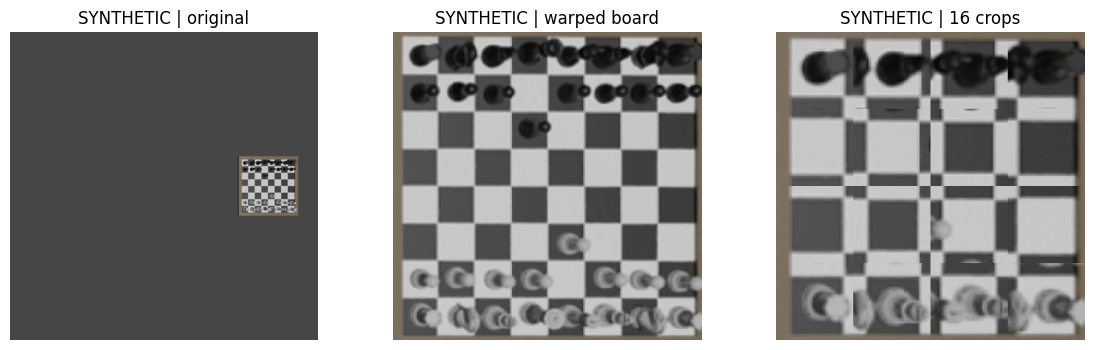

In [ ]:
# Sanity check: show preprocessing on 1 synthetic + 1 real image (warped board + sample squares)
import matplotlib.pyplot as plt
import numpy as np
import math

def x_at_y(line, y):
    """For line x*cos(t)+y*sin(t)=rho, compute x at given y."""
    rho, t = line
    c, s = math.cos(t), math.sin(t)
    if abs(c) < 1e-9:
        return None
    return (rho - y*s) / c

def y_at_x(line, x):
    """For line x*cos(t)+y*sin(t)=rho, compute y at given x."""
    rho, t = line
    c, s = math.cos(t), math.sin(t)
    if abs(s) < 1e-9:
        return None
    return (rho - x*c) / s

def sort_vertical_lines_left_to_right(v_lines, img_h):
    ymid = img_h / 2.0
    scored = []
    for line in v_lines:
        xv = x_at_y(line, ymid)
        if xv is not None and np.isfinite(xv):
            scored.append((xv, line))
    scored.sort(key=lambda z: z[0])
    return [l for _, l in scored]

def sort_horizontal_lines_top_to_bottom(h_lines, img_w):
    xmid = img_w / 2.0
    scored = []
    for line in h_lines:
        yh = y_at_x(line, xmid)
        if yh is not None and np.isfinite(yh):
            scored.append((yh, line))
    scored.sort(key=lambda z: z[0])
    return [l for _, l in scored]

def _show_triplet(title, img_bgr, board_bgr, squares_bgr):
    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)); plt.title(title+" | original"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(cv2.cvtColor(board_bgr, cv2.COLOR_BGR2RGB)); plt.title(title+" | warped board"); plt.axis("off")

    # show 16 squares
    grid = np.zeros((4*SQUARE_SIZE, 4*SQUARE_SIZE, 3), dtype=np.uint8)
    for k in range(16):
        rr = k//4; cc = k%4
        grid[rr*SQUARE_SIZE:(rr+1)*SQUARE_SIZE, cc*SQUARE_SIZE:(cc+1)*SQUARE_SIZE] = squares_bgr[k]
    plt.subplot(1,3,3); plt.imshow(cv2.cvtColor(grid, cv2.COLOR_BGR2RGB)); plt.title(title+" | 16 crops"); plt.axis("off")
    plt.show()

def _sample_squares(board_bgr, use_context=True, k=1.6):
    coords = [(0,0),(0,2),(0,5),(0,7),
              (2,0),(2,2),(2,5),(2,7),
              (5,0),(5,2),(5,5),(5,7),
              (7,0),(7,2),(7,5),(7,7)]
    out=[]
    for r,c in coords:
        if use_context:
            out.append(crop_context_square_from_board(board_bgr, r, c, k=k, out_size=SQUARE_SIZE))
        else:
            out.append(crop_square_from_board(board_bgr, r, c, out_size=SQUARE_SIZE))
    return out

syn_rows = samples_df[samples_df["domain"]=="synthetic"]
real_rows = samples_df[samples_df["domain"]=="real"]

if len(syn_rows)==0 or len(real_rows)==0:
    print("Need both synthetic and real samples in samples_df to run this.")
else:
    syn = syn_rows.sample(1, random_state=1).iloc[0]
    real = real_rows.sample(1, random_state=1).iloc[0]

    syn_img = cv2.imread(syn["image_path"])
    real_img = cv2.imread(real["image_path"])

    syn_board, syn_dbg = preprocess_board(syn_img, out_size=MAX_BOARD_SIZE, roi_min_area=0.0005, domain="synthetic")
    real_board, real_dbg = preprocess_board_real(real_img, out_size=MAX_BOARD_SIZE, fallback=True)

    _show_triplet("SYNTHETIC", syn_img, syn_board, _sample_squares(syn_board, use_context=True, k=1.5))
    _show_triplet("REAL", real_img, real_board, _sample_squares(real_board, use_context=True, k=1.6))

    print("Synthetic preprocess method:", syn_dbg.get("method"))
    print("Real preprocess method:", real_dbg.get("method"))


In [ ]:
import os, glob, random
SYN_MAIN_ROOT = "./chess_data/highres_main/high_res_data"
syn_main_paths = sorted(glob.glob(os.path.join(SYN_MAIN_ROOT, "**", "images", "*.png"), recursive=True))
print("synthetic_main images:", len(syn_main_paths))
print("example:", syn_main_paths[0] if len(syn_main_paths) else "NONE")

In [ ]:
from PIL import Image
import random
import cv2

N_BOARDS = 3
CROPS_PER_BOARD = 12
K_MIN, K_MAX = 1.4, 2.0
OUT_SIZE = 224

def show_grid(ax, board_img, n=8):
    w, h = board_img.size
    for i in range(1, n):
        ax.axhline(i*h/n, color="lime", lw=1)
        ax.axvline(i*w/n, color="lime", lw=1)

for _ in range(N_BOARDS):
    path = random.choice(syn_main_paths)
    img_pil = Image.open(path).convert("RGB")
    img_bgr = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

    board_bgr, dbg = preprocess_board(img_bgr, roi_min_area=0.0005)
    board = Image.fromarray(cv2.cvtColor(board_bgr, cv2.COLOR_BGR2RGB))

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(board)
    show_grid(ax, board)
    ax.set_title(f"synthetic_main processed board\n{path}")
    ax.axis("off")
    plt.show()

    crops = []
    titles = []
    for i in range(CROPS_PER_BOARD):
        r = random.randint(0, 7)
        c = random.randint(0, 7)
        k = random.uniform(K_MIN, K_MAX)

        crop = crop_context_square_from_board(board, r, c, k, out_size=OUT_SIZE)
        crops.append(crop)
        titles.append(f"(r={r},c={c}) k={k:.2f}")

    cols = 6
    rows = int(np.ceil(len(crops)/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
    axes = np.array(axes).reshape(-1)

    for i, ax in enumerate(axes):
        if i < len(crops):
            ax.imshow(crops[i])
            ax.set_title(titles[i], fontsize=9)
        ax.axis("off")

    plt.suptitle("Context-crops preview - synthetic_main", fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
import matplotlib.patches as patches

def draw_grid(ax, W, H, n=8, color="lime", lw=1):
    for i in range(1, n):
        ax.axhline(i * H / n, color=color, lw=lw)
        ax.axvline(i * W / n, color=color, lw=lw)

def get_context_rect(W, H, r, c, k):
    sq_w = W / 8.0
    sq_h = H / 8.0

    cx = (c + 0.5) * sq_w
    cy = (r + 0.5) * sq_h

    win_w = k * sq_w
    win_h = k * sq_h

    x0 = cx - win_w / 2
    y0 = cy - win_h / 2

    return x0, y0, win_w, win_h

# choose a random square and k
W, H = board.size
r = random.randint(0, 7)
c = random.randint(0, 7)
k = random.uniform(1.4, 2.0)

# draw
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(board)
draw_grid(ax, W, H)

x0, y0, ww, hh = get_context_rect(W, H, r, c, k)

# draw context crop window in red
rect = patches.Rectangle((x0, y0), ww, hh, linewidth=2, edgecolor="red", facecolor="none")
ax.add_patch(rect)

ax.set_title(f"Grid + context crop window (r={r}, c={c}, k={k:.2f})")
ax.axis("off")
plt.show()

# also show actual crop that goes into the model
crop = crop_context_square_from_board(board, r, c, k, out_size=224)
plt.figure(figsize=(3,3))
plt.imshow(crop)
plt.title("Actual training crop")
plt.axis("off")
plt.show()

## 5) Warp quality scoring + filtering


In [ ]:
def warp_quality_score(board_bgr: np.ndarray) -> float:
    gray = cv2.cvtColor(board_bgr, cv2.COLOR_BGR2GRAY)
    S = gray.shape[0]
    step = S // 8
    if step < 8:
        return 0.0
    g8 = gray[:step*8, :step*8].reshape(8, step, 8, step).mean(axis=(1,3))
    return _alternation_score(g8)

def score_all_samples(df):
    scores = []
    methods = []

    for _, r in tqdm(df.iterrows(), total=len(df), desc="Scoring warps"):
        bgr = cv2.imread(r["image_path"])
        if bgr is None:
            scores.append(0.0)
            methods.append("read_fail")
            continue

        domain = r["domain"]
        board, dbg = preprocess_board_domain(bgr, domain=domain, out_size=512)

        scores.append(warp_quality_score(board))
        methods.append(dbg.get("method", "?"))

    out = df.copy()
    out["warp_quality"] = scores
    out["warp_method"] = methods
    return out

scored_df = score_all_samples(samples_df)
print(scored_df.groupby("domain")["warp_quality"].describe())

good_df = scored_df[scored_df["warp_quality"] >= WARP_QUALITY_TH].reset_index(drop=True)
bad_df  = scored_df[scored_df["warp_quality"] <  WARP_QUALITY_TH].reset_index(drop=True)

print("GOOD:", len(good_df), "BAD:", len(bad_df))
print("Bad by domain:\n", bad_df["domain"].value_counts())

## 6) Splits


In [ ]:
def split_by_game_id(df, val_frac=0.06, test_frac=0.06, seed=42):
    assert "game_id" in df.columns, "Expected game_id column"
    games = sorted(df["game_id"].unique().tolist())
    rng = np.random.RandomState(seed)
    rng.shuffle(games)

    n = len(games)
    n_test = max(1, int(round(test_frac * n))) if n >= 3 else 0
    n_val  = max(1, int(round(val_frac  * n))) if n - n_test >= 2 else 0

    if n_test == 0 or n_val == 0:
        n_val = max(1, int(round(0.06 * n)))
        val_games = set(games[:n_val])
        test_games = set()
        train_games = set(games[n_val:])
    else:
        test_games = set(games[:n_test])
        val_games  = set(games[n_test:n_test+n_val])
        train_games = set(games[n_test+n_val:])

    train_df = df[df["game_id"].isin(train_games)].reset_index(drop=True)
    val_df   = df[df["game_id"].isin(val_games)].reset_index(drop=True)
    test_df  = df[df["game_id"].isin(test_games)].reset_index(drop=True)
    
    return train_df, val_df, test_df

In [ ]:
good_df["game_id"] = good_df["game_folder"].apply(lambda p: os.path.normpath(p).split(os.sep)[-1])

real_df = good_df[good_df["domain"]=="real"].copy()
real_games = sorted(real_df["game_id"].unique())
random.seed(42); random.shuffle(real_games)
mid = len(real_games)//2
real_val_games = set(real_games[:mid])
real_test_games = set(real_games[mid:])
real_val_df  = real_df[real_df["game_id"].isin(real_val_games)].reset_index(drop=True)
real_test_df = real_df[real_df["game_id"].isin(real_test_games)].reset_index(drop=True)

syn_df = good_df[good_df["domain"]=="synthetic"].copy()
syn_games = sorted(syn_df["game_id"].unique())
random.seed(42); random.shuffle(syn_games)
k = max(1, int(len(syn_games) * 0.10))
syn_val_games = set(syn_games[:k])
syn_train_games = set(syn_games[k:])
syn_train_df, syn_val_df, syn_test_df = split_by_game_id(syn_df, val_frac=0.06, test_frac=0.06, seed=42)

print("SYN games:", syn_df["game_id"].nunique())
print("SYN train images:", len(syn_train_df), "| games:", syn_train_df["game_id"].nunique())
print("SYN val images  :", len(syn_val_df),   "| games:", syn_val_df["game_id"].nunique())
print("SYN test images :", len(syn_test_df),  "| games:", (syn_test_df["game_id"].nunique() if len(syn_test_df) else 0))

## 7) Augmentations + Dataset + Dataloaders


In [ ]:
def build_transforms(train: bool, image_size: int = 96):
    if train:
        return A.Compose([
            A.RandomBrightnessContrast(p=0.8),
            A.HueSaturationValue(p=0.7),
            A.RGBShift(p=0.4),
            A.ChannelShuffle(p=0.1),
            A.OneOf([
                A.GaussianBlur(p=1.0),
                A.MotionBlur(p=1.0),
                A.MedianBlur(p=1.0),
            ], p=0.25),
            A.GaussNoise(p=0.35),
            A.RandomShadow(p=0.25),
            A.Affine(p=0.15),
            A.ShiftScaleRotate(shift_limit=0.04, scale_limit=0.10, rotate_limit=5, border_mode=cv2.BORDER_REFLECT, p=0.6),
            A.Perspective(scale=(0.015, 0.05), p=0.2),
            A.ImageCompression(quality_lower=40, quality_upper=95, p=0.25),
            A.RandomGamma(gamma_limit=(70, 140), p=0.30),
            A.CoarseDropout(p=0.15),
            A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
            ToTensorV2(),
        ])

class SquareCubeDataset(Dataset):
    def __init__(self, df: pd.DataFrame, cube_size: int = 128, transform=None, cache_warped: bool = False,
                 train: bool = False, use_context_crop: bool = True, context_k_range: Tuple[float,float]=(1.4,2.0), context_k_eval: float = 1.6):
        self.df = df.reset_index(drop=True)
        self.cube_size = cube_size
        self.transform = transform
        self.cache_warped = cache_warped
        self.train = bool(train)
        self.use_context_crop = bool(use_context_crop)
        self.context_k_range = tuple(context_k_range)
        self.context_k_eval = float(context_k_eval)
        self._cache = {}
        self.n = len(self.df) * 64

    def __len__(self):
        return self.n

    
    def _get_board(self, board_idx: int):
        if self.cache_warped and board_idx in self._cache:
            return self._cache[board_idx]
        row = self.df.iloc[board_idx]
        bgr = cv2.imread(row["image_path"])
        if bgr is None:
            raise FileNotFoundError(row["image_path"])

        # Switch preprocessing by domain:
        if str(row.get("domain", "synthetic")).lower().startswith("real"):
            board, _ = preprocess_board_real(bgr, out_size=MAX_BOARD_SIZE, fallback=True)
        else:
            roi_min_area = 0.0005 if ('synthetic_main' in str(row.get('image_path', row.get('path', '')))) else 0.001
            board, _ = preprocess_board(bgr, out_size=MAX_BOARD_SIZE, roi_min_area=roi_min_area, domain="synthetic")

        if self.cache_warped:
            self._cache[board_idx] = board
        return board

    def __getitem__(self, idx):
        board_idx = idx // 64
        square_idx = idx % 64
        r = square_idx // 8
        c = square_idx % 8

        row = self.df.iloc[board_idx]
        board = self._get_board(board_idx)

        if self.use_context_crop:
            if self.train:
                k = random.uniform(self.context_k_range[0], self.context_k_range[1])
            else:
                k = self.context_k_eval
            cube_bgr = crop_context_square_from_board(board, r, c, k=k, out_size=self.cube_size)
        else:
            cube_bgr = crop_square_from_board(board, r, c, out_size=self.cube_size)

        grid = fen_to_grid(row["fen"])
        y = int(grid[r, c])

        if y == 0:
            bs = blur_score_laplacian_bgr(cube_bgr)
            ber = border_edge_ratio_bgr(cube_bgr, border=10)
            if (bs < 15.0) or (ber > 2.6):
                j = random.randrange(0, len(self.df) * 64)
                return self.__getitem__(j)

        cube_rgb = cv2.cvtColor(cube_bgr, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            x = self.transform(image=cube_rgb)["image"]
        else:
            x = torch.from_numpy(cube_rgb).permute(2,0,1).float() / 255.0

        meta = {"domain": row["domain"], "img_path": row["image_path"], "r": r, "c": c,
                "warp_method": row.get("warp_method", "?"), "warp_quality": float(row.get("warp_quality", -1.0))}
        return x, y, meta

def make_loader(
    df,
    train: bool,
    batch_size: int,
    num_workers: int,
    cube_size: int = 128,
    cache_warped: bool = False,
):
    ds = SquareCubeDataset(
        df,
        cube_size=cube_size,
        transform=build_transforms(train=train),
        cache_warped=cache_warped,
        train=train,
        use_context_crop=True,
        context_k_range=(1.4, 2.0),
        context_k_eval=1.6,
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=train,
        num_workers=num_workers,
        pin_memory=True,
        persistent_workers=(num_workers > 0),
    )

In [ ]:
from torch.utils.data import RandomSampler, WeightedRandomSampler

def make_loader_limited(df, train: bool, batch_size: int, num_workers: int, cache_warped: bool,
                        epoch_samples: int = 2000):
    tf = build_transforms(train=train, image_size=SQUARE_SIZE)
    ds = SquareCubeDataset(df, cube_size=SQUARE_SIZE, transform=tf, cache_warped=cache_warped,
                      train=train, use_context_crop=True, context_k_range=(1.4,2.0), context_k_eval=1.6)

    if train:
        w_hard = compute_square_weights_for_df(df, hard_empty_boost=3.0)
        sampler = WeightedRandomSampler(weights=torch.from_numpy(w_hard), num_samples=epoch_samples, replacement=True)
        loader = DataLoader(ds, batch_size=batch_size, sampler=sampler,
                            num_workers=num_workers, pin_memory=True)
    else:
        loader = DataLoader(ds, batch_size=batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=True)

    return loader

## 8) Model + Train loop

In [ ]:
import torchvision
import torch
import torch.nn as nn
from sklearn.metrics import f1_score

class SquareClassifier(nn.Module):
    def __init__(self, num_classes: int = 13, dropout: float = 0.2):
        super().__init__()
        net = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
        in_features = net.fc.in_features
        net.fc = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(in_features, num_classes),
        )
        self.net = net

    def forward(self, x):
        return self.net(x)

@torch.no_grad()
def evaluate_square_level(model, loader, criterion=None):
    model.eval()
    total_loss = 0.0
    ys, ps = [], []
    for x, y, _ in tqdm(loader, desc="Validating", leave=False):
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        logits = model(x)
        if criterion is not None:
            total_loss += float(criterion(logits, y).item()) * x.size(0)
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        ys.append(y.detach().cpu().numpy())
        ps.append(preds)
    y_true = np.concatenate(ys) if ys else np.array([])
    y_pred = np.concatenate(ps) if ps else np.array([])
    avg_loss = total_loss / max(1, len(loader.dataset))
    return avg_loss, y_true, y_pred

def train_model(train_loader, val_loader, run_dir: str, epochs: int = 8, lr: float = 3e-4, weight_decay: float = 1e-4,
                label_smoothing: float = 0.05, dropout: float = 0.2, grad_accum_steps: int = 4):
    os.makedirs(run_dir, exist_ok=True)
    gpu_cleanup()

    model = SquareClassifier(num_classes=len(CLASSES), dropout=dropout).to(DEVICE)
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    steps_per_epoch = max(1, len(train_loader)//grad_accum_steps)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, epochs * steps_per_epoch))

    scaler = torch.amp.GradScaler('cuda', enabled=(DEVICE == "cuda"))

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_val_acc = -1.0
    best_path = None

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        optimizer.zero_grad(set_to_none=True)
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")

        for step, batch in enumerate(pbar, start=1):
            if len(batch) == 3:
                x, y, _ = batch
            else:
                x, y = batch

            x = x.to(DEVICE, non_blocking=True)
            y = y.to(DEVICE, non_blocking=True)

            with torch.amp.autocast('cuda', enabled=(DEVICE == "cuda")):
                logits = model(x)
                loss = criterion(logits, y) / grad_accum_steps

            scaler.scale(loss).backward()

            running_loss += loss.item() * x.size(0) * grad_accum_steps
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += x.size(0)

            if step % grad_accum_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
                scheduler.step()

            pbar.set_postfix({"loss": running_loss / max(1, total), "acc": correct / max(1, total), "lr": scheduler.get_last_lr()[0]})

        if (step % grad_accum_steps) != 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()

        train_loss = running_loss / max(1, total)
        train_acc = correct / max(1, total)

        val_loss, y_true, y_pred = evaluate_square_level(model, val_loader, criterion=criterion)

        val_acc = float((y_pred == y_true).mean()) if len(y_true) else 0.0
        
        val_macro_f1 = float(f1_score(y_true, y_pred, average="macro")) if len(y_true) else 0.0

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"\nEpoch {epoch} summary: train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
              f"val_loss={val_loss:.4f} val_acc={val_acc:.4f} val_macroF1={val_macro_f1:.4f}")

        ckpt_path = os.path.join(run_dir, f"checkpoint_epoch_{epoch:03d}.pt")
        save_checkpoint(ckpt_path, model, optimizer, epoch,
                        cfg={"epochs": epochs, "lr": lr, "weight_decay": weight_decay, "label_smoothing": label_smoothing,
                             "dropout": dropout, "grad_accum_steps": grad_accum_steps},
                        best_val_acc=max(best_val_acc, val_acc))

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_path = os.path.join(run_dir, "best.pt")
            save_checkpoint(best_path, model, optimizer, epoch,
                            cfg={"epochs": epochs, "lr": lr, "weight_decay": weight_decay, "label_smoothing": label_smoothing,
                                 "dropout": dropout, "grad_accum_steps": grad_accum_steps},
                            best_val_acc=best_val_acc)

        plot_training_curves(history, title=f"{os.path.basename(run_dir)} (up to epoch {epoch})")

    print("Best val acc:", best_val_acc, "Best checkpoint:", best_path)
    return model, history, best_path

## 9) ExpA (synthetic only)


In [ ]:
def blur_score_laplacian_bgr(bgr_uint8):
    g = cv2.cvtColor(bgr_uint8, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(g, cv2.CV_64F).var()

def border_edge_ratio_bgr(bgr_uint8, border=10):
    g = cv2.cvtColor(bgr_uint8, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(g, 80, 160)
    b = border
    border_mask = np.zeros_like(edges, dtype=np.uint8)
    border_mask[:b,:] = 1; border_mask[-b:,:] = 1
    border_mask[:,:b] = 1; border_mask[:,-b:] = 1
    border_mean = edges[border_mask==1].mean()
    center_mean = edges[border_mask==0].mean()
    return float(border_mean / (center_mean + 1e-6))

In [ ]:
def save_checkpoint(path, model, optimizer, epoch, cfg=None, best_val_acc=None):
    ckpt = {
        "epoch": int(epoch),
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "classes": list(CLASSES),           
    }
    if cfg is not None:
        ckpt["cfg"] = cfg
    if best_val_acc is not None:
        ckpt["best_val_acc"] = float(best_val_acc)

    torch.save(ckpt, path)

def evaluate_and_report(model, loader, name: str):
    val_loss, y, p = evaluate_square_level(model, loader, criterion=None)
    print(f"=== {name} ===")
    print("Square accuracy:", accuracy_score(y, p))
    print("Macro F1:", f1_score(y, p, average="macro"))
    print(classification_report(y, p, target_names=CLASSES, digits=4))
    cm = confusion_matrix(y, p, labels=list(range(len(CLASSES))))
    plot_confusion(cm, title=f"Confusion Matrix - {name}")
    return {"loss": val_loss, "y": y, "p": p}

def evaluate_square_level(model, loader, criterion=None):
    model.eval()
    total_loss = 0.0
    seen = 0
    ys, ps = [], []
    for x, y, _ in tqdm(loader, desc="Validating", leave=False):
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        logits = model(x)
        if criterion is not None:
            total_loss += float(criterion(logits, y).item()) * x.size(0)
        seen += x.size(0)

        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        ys.append(y.detach().cpu().numpy())
        ps.append(preds)

    y_true = np.concatenate(ys) if ys else np.array([])
    y_pred = np.concatenate(ps) if ps else np.array([])
    avg_loss = total_loss / max(1, seen) if criterion is not None else float("nan")
    return avg_loss, y_true, y_pred

def plot_confusion(cm: np.ndarray, title: str):
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm)
    ax.set_title(title)
    ax.set_xticks(range(len(CLASSES))); ax.set_yticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, rotation=90); ax.set_yticklabels(CLASSES)
    plt.colorbar(im, ax=ax)
    plt.show()

def plot_training_curves(history, title="Training curves"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(history["train_loss"], label="train")
    axes[0].plot(history["val_loss"], label="val")
    axes[0].set_title("Loss"); axes[0].legend()
    axes[1].plot(history["train_acc"], label="train")
    axes[1].plot(history["val_acc"], label="val")
    axes[1].set_title("Accuracy"); axes[1].legend()
    plt.suptitle(title)
    plt.show()

In [ ]:
from torch.utils.data import RandomSampler

def make_loader_limited(df, train: bool, batch_size: int, num_workers: int,
                        cache_warped: bool, epoch_samples: int = 20000):
    tf = build_transforms(train=train, image_size=SQUARE_SIZE)
    ds = SquareCubeDataset(df, cube_size=SQUARE_SIZE, transform=tf, cache_warped=cache_warped,
                      train=train, use_context_crop=True, context_k_range=(1.4,2.0), context_k_eval=1.6)

    sampler = RandomSampler(ds, replacement=True, num_samples=epoch_samples)
    loader = DataLoader(ds, batch_size=batch_size, sampler=sampler,
                        num_workers=num_workers, pin_memory=True)
    return loader

In [ ]:
BATCH = 16 if DEVICE=="cuda" else 8
NW = 2                               
EPOCH_SAMPLES = 30000

syn_train_loader = make_loader_limited(syn_train_df, train=True, batch_size=BATCH, num_workers=NW,
                                       cache_warped=False, epoch_samples=EPOCH_SAMPLES)
syn_val_loader   = make_loader(syn_val_df, train=False, batch_size=BATCH, num_workers=NW,
                               cache_warped=False)
real_test_loader = make_loader_limited(real_test_df, train=False, batch_size=BATCH, num_workers=NW,
                                       cache_warped=False)

VAL_SAMPLES = 3000

syn_val_loader = make_loader_limited(
    syn_val_df, train=False,
    batch_size=BATCH, num_workers=NW,
    cache_warped=False,
    epoch_samples=VAL_SAMPLES
)

run_dir_A = "./runs/expA_synthetic_only"
model_A, hist_A, best_A = train_model(
    syn_train_loader, syn_val_loader,
    run_dir=run_dir_A,
    epochs=1,
    lr=3e-4,
    weight_decay=1e-4,
    label_smoothing=0.06,
    dropout=0.2,
    grad_accum_steps=4
)

print("\n--- Real TEST zero-shot (ExpA) ---")
evaluate_and_report(model_A, real_test_loader, "Real TEST zero-shot (ExpA)")

## 10) Reconstruction helpers

In [ ]:
print("SYN splits:",
      "train", len(syn_train_df),
      "val", len(syn_val_df),
      "test", len(syn_test_df))

print("REAL splits:",
      "val", len(real_val_df),
      "test", len(real_test_df))

In [ ]:
# Cache splits to disk
SPLIT_DIR = "./splits_cache"
os.makedirs(SPLIT_DIR, exist_ok=True)

syn_train_df.to_csv(f"{SPLIT_DIR}/syn_train.csv", index=False)
syn_val_df.to_csv(f"{SPLIT_DIR}/syn_val.csv", index=False)
syn_test_df.to_csv(f"{SPLIT_DIR}/syn_test.csv", index=False)

real_val_df.to_csv(f"{SPLIT_DIR}/real_val.csv", index=False)
real_test_df.to_csv(f"{SPLIT_DIR}/real_test.csv", index=False)

print("cached to", SPLIT_DIR)
!ls -lh splits_cache

In [ ]:
!ls runs/expA_synthetic_only

In [ ]:
real_train_df = real_df[~real_df["game_id"].isin(real_val_games.union(real_test_games))].reset_index(drop=True)
print("REAL splits:",
      "train", len(real_train_df),
      "val", len(real_val_df),
      "test", len(real_test_df))

In [ ]:
real_train_df.to_csv(f"{SPLIT_DIR}/real_train.csv", index=False)
print("real_train cached too")
!ls -lh splits_cache

In [ ]:
class EfficientNetSquareClassifier(nn.Module):
    def __init__(self, num_classes: int = 13, dropout: float = 0.2, use_imagenet: bool = True):
        super().__init__()
        weights = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1 if use_imagenet else None
        self.net = torchvision.models.efficientnet_b0(weights=weights)
        in_features = self.net.classifier[1].in_features
        self.net.classifier[1] = nn.Sequential(nn.Dropout(p=dropout), nn.Linear(in_features, num_classes))

    def forward(self, x):
        return self.net(x)

In [ ]:
def load_checkpoint_model(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location=DEVICE, weights_only=False)
    if "classes" in ckpt:
        saved_classes = ckpt["classes"]
        if list(saved_classes) != list(CLASSES):
            raise ValueError(
                "CLASSES mismatch between checkpoint and current session.\n"
                f"Checkpoint CLASSES[:10]={saved_classes[:10]}\n"
                f"Session    CLASSES[:10]={CLASSES[:10]}"
            )
    dropout = ckpt.get("cfg", {}).get("dropout", 0.2)
    model = SquareClassifier(num_classes=len(CLASSES), dropout=dropout)
    model.load_state_dict(ckpt["model_state"], strict=True)
    model = model.to(DEVICE).eval()
    return model

In [ ]:
model_A = load_checkpoint_model("./runs/expA_synthetic_only/best.pt")

In [ ]:
import numpy as np

assert "real_df" in globals(), "real_df not defined. You need your real dataframe before splitting."
print("Total real images:", len(real_df))
print("Unique real games:", real_df['game_id'].nunique() if 'game_id' in real_df.columns else real_df['game_folder'].nunique())

if "game_id" not in real_df.columns:
    real_df = real_df.copy()
    real_df["game_id"] = real_df["game_folder"].apply(lambda p: os.path.normpath(p).split(os.sep)[-1])

games = sorted(real_df["game_id"].unique())
rng = np.random.RandomState(42)
rng.shuffle(games)

n_games = len(games)
if n_games < 3:
    print("Too few real games to split by game safely. Splitting by images instead.")
    idx = np.arange(len(real_df))
    rng.shuffle(idx)
    n_test = max(1, int(0.2 * len(idx)))
    n_val  = max(1, int(0.2 * len(idx)))
    test_idx = idx[:n_test]
    val_idx  = idx[n_test:n_test+n_val]
    train_idx= idx[n_test+n_val:]
    real_train_df = real_df.iloc[train_idx].reset_index(drop=True)
    real_val_df   = real_df.iloc[val_idx].reset_index(drop=True)
    real_test_df  = real_df.iloc[test_idx].reset_index(drop=True)
else:
    # split by games, guarantee at least 1 game in each split
    n_test = max(1, int(round(0.2 * n_games)))
    n_val  = max(1, int(round(0.2 * n_games)))
    if n_test + n_val >= n_games:
        n_test = 1
        n_val = 1

    test_games = set(games[:n_test])
    val_games  = set(games[n_test:n_test+n_val])
    train_games= set(games[n_test+n_val:])

    real_train_df = real_df[real_df["game_id"].isin(train_games)].reset_index(drop=True)
    real_val_df   = real_df[real_df["game_id"].isin(val_games)].reset_index(drop=True)
    real_test_df  = real_df[real_df["game_id"].isin(test_games)].reset_index(drop=True)

print("REAL split sizes:")
print("  train:", len(real_train_df), "games:", real_train_df["game_id"].nunique())
print("  val  :", len(real_val_df),   "games:", real_val_df["game_id"].nunique())
print("  test :", len(real_test_df),  "games:", real_test_df["game_id"].nunique())

assert len(real_train_df) > 0, "Real train is still empty. Lower warp threshold or include more real images."
assert len(real_val_df) > 0, "Real val is empty."
assert len(real_test_df) > 0, "Real test is empty."

In [ ]:
def plot_confusion_purple(y_true, y_pred, class_names, title="Confusion Matrix", normalize=True):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    if normalize:
        cm = cm.astype(np.float32)
        row_sums = cm.sum(axis=1, keepdims=True)
        cm = np.divide(cm, np.maximum(row_sums, 1), where=row_sums!=0)

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, cmap="Purples")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.xticks(range(len(class_names)), class_names, rotation=90)
    plt.yticks(range(len(class_names)), class_names)

    plt.tight_layout()
    plt.show()

## Exp B - (Fine-tune on REAL)

In [ ]:
#setting up environment again if we are not running previous cells
import os, random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
import cv2

#sanity
need = [
    "real_train_df","real_val_df","real_test_df",
    "SquareClassifier",
    "build_transforms",
    "preprocess_board_real",
    "crop_context_square_from_board",
    "crop_square_from_board",
    "fen_to_grid",
    "compute_class_weights_from_df",
    "CLASSES","DEVICE"
]
missing = [k for k in need if k not in globals()]
assert not missing, f"Missing: {missing}"

RUN_DIR_B = "./runs/expB_finetune_real"
os.makedirs(RUN_DIR_B, exist_ok=True)

CUBE_SIZE = 128
WARP_SIZE = 512
BATCH = 128 if torch.cuda.is_available() else 32
NW = 2

EPOCHS = 1
LR = 1e-4
WD = 1e-4
LABEL_SMOOTH = 0.04

# dataset
class RealSquareDataset(Dataset):
    def __init__(self, df, cube_size=128, warped_size=512, transform=None, train=False,
                 use_context=True, k_range=(1.4,2.0), k_eval=1.6):
        self.df = df.reset_index(drop=True)
        self.cube_size = int(cube_size)
        self.warped_size = int(warped_size)
        self.transform = transform
        self.train = bool(train)
        self.use_context = bool(use_context)
        self.k_range = tuple(k_range)
        self.k_eval = float(k_eval)
        self.n = len(self.df) * 64

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        board_idx = idx // 64
        sq = idx % 64
        r, c = sq // 8, sq % 8
        row = self.df.iloc[board_idx]

        bgr = cv2.imread(row["image_path"])
        if bgr is None:
            raise FileNotFoundError(row["image_path"])

        board, _ = preprocess_board_real(bgr, out_size=self.warped_size, fallback=True)

        if self.use_context:
            k = random.uniform(*self.k_range) if self.train else self.k_eval
            cube = crop_context_square_from_board(board, r, c, k=k, out_size=self.cube_size)
        else:
            cube = crop_square_from_board(board, r, c, out_size=self.cube_size)

        grid = fen_to_grid(row["fen"])
        
        y = int(grid[r, c])
        if y == 0:
            bs = blur_score_laplacian_bgr(cube)
            ber = border_edge_ratio_bgr(cube, border=10)
            if (bs < 15.0) or (ber > 2.6):
                j = random.randrange(0, len(self.df) * 64)
                return self.__getitem__(j)

        cube_rgb = cv2.cvtColor(cube, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            x = self.transform(image=cube_rgb)["image"]
        else:
            x = torch.from_numpy(cube_rgb).permute(2,0,1).float() / 255.0

        return x, y, {"img_path": row["image_path"], "r": r, "c": c}

def make_loader(df, train):
    tf = build_transforms(train=train, image_size=CUBE_SIZE)
    ds = RealSquareDataset(df, cube_size=CUBE_SIZE, warped_size=WARP_SIZE, transform=tf, train=train, use_context=True)
    return DataLoader(ds, batch_size=BATCH, shuffle=train, num_workers=NW, pin_memory=True,
                      persistent_workers=(NW > 0))

train_loader = make_loader(real_train_df, train=True)
val_loader   = make_loader(real_val_df,   train=False)
test_loader  = make_loader(real_test_df,  train=False)

#helpers
def save_checkpoint(path, model, optimizer, epoch, cfg, best_metric):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        "epoch": int(epoch),
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "cfg": cfg,
        "best_metric": float(best_metric),
        "classes": CLASSES
    }, path)

@torch.no_grad()
def eval_loader(model, loader, criterion=None):
    model.eval()
    ys, ps = [], []
    total_loss = 0.0
    n = 0
    for x, y, _ in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        logits = model(x)
        if criterion is not None:
            total_loss += float(criterion(logits, y).item()) * x.size(0)
        pred = logits.argmax(dim=1)
        ys.append(y.detach().cpu().numpy())
        ps.append(pred.detach().cpu().numpy())
        n += x.size(0)

    if n == 0:
        raise RuntimeError("Eval loader produced 0 samples (dataset empty or worker crash).")

    y = np.concatenate(ys)
    p = np.concatenate(ps)
    acc = float((p == y).mean())
    macro_f1 = float(f1_score(y, p, average="macro"))
    loss = float(total_loss / n) if criterion is not None else 0.0
    return {"loss": loss, "acc": acc, "macro_f1": macro_f1, "y": y, "p": p}

def plot_curves(hist, title):
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].plot(hist["train_loss"], label="train")
    ax[0].plot(hist["val_loss"], label="val")
    ax[0].set_title("Loss"); ax[0].legend()
    ax[1].plot(hist["train_acc"], label="train")
    ax[1].plot(hist["val_acc"], label="val")
    ax[1].set_title("Acc"); ax[1].legend()
    plt.suptitle(title); plt.show()

# model / loss
model = SquareClassifier(num_classes=len(CLASSES), dropout=0.2).to(DEVICE)

class_w = compute_class_weights_from_df(real_train_df).to(DEVICE)
print("Class weights (real-train):", {CLASSES[i]: float(class_w[i]) for i in range(len(CLASSES))})

criterion = nn.CrossEntropyLoss(weight=class_w, label_smoothing=LABEL_SMOOTH)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS * len(train_loader))
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE == "cuda"))

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "val_f1": []}
best_f1 = -1.0
best_path = os.path.join(RUN_DIR_B, "best.pt")

for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    pbar = tqdm(train_loader, desc=f"ExpB Epoch {epoch}/{EPOCHS}")

    for x, y, _ in pbar:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        running_loss += float(loss.item()) * x.size(0)
        pred = logits.argmax(dim=1)
        correct += int((pred == y).sum().item())
        total += int(x.size(0))
        pbar.set_postfix(loss=running_loss/max(1,total), acc=correct/max(1,total), lr=scheduler.get_last_lr()[0])

    train_loss = running_loss / max(1, total)
    train_acc  = correct / max(1, total)

    val_m = eval_loader(model, val_loader, criterion=criterion)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_m["loss"])
    history["val_acc"].append(val_m["acc"])
    history["val_f1"].append(val_m["macro_f1"])

    print(f"\n[ExpB] epoch {epoch}: train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
          f"val_loss={val_m['loss']:.4f} val_acc={val_m['acc']:.4f} val_f1={val_m['macro_f1']:.4f}")

    save_checkpoint(
        os.path.join(RUN_DIR_B, f"checkpoint_epoch_{epoch:03d}.pt"),
        model, optimizer, epoch,
        cfg={"exp":"B_finetune_real", "epochs":EPOCHS, "lr":LR, "wd":WD, "label_smoothing":LABEL_SMOOTH, "cube":CUBE_SIZE},
        best_metric=max(best_f1, val_m["macro_f1"])
    )

    if val_m["macro_f1"] > best_f1:
        best_f1 = val_m["macro_f1"]
        save_checkpoint(best_path, model, optimizer, epoch,
                        cfg={"exp":"B_finetune_real", "epochs":EPOCHS, "lr":LR, "wd":WD, "label_smoothing":LABEL_SMOOTH, "cube":CUBE_SIZE},
                        best_metric=best_f1)
        print(f" new best by VAL macro-F1: {best_path} (f1={best_f1:.4f})")

    plot_curves(history, title=f"ExpB up to epoch {epoch}")

print("\nBest val macro-F1:", best_f1)
print("Best checkpoint:", best_path)

#final test
test_m = eval_loader(model, test_loader, criterion=None)
print("\n=== REAL TEST (ExpB) ===")
print("Square accuracy:", accuracy_score(test_m["y"], test_m["p"]))
print("Macro F1:", f1_score(test_m["y"], test_m["p"], average="macro"))
print(classification_report(test_m["y"], test_m["p"], target_names=CLASSES, digits=4, zero_division=0))
plot_confusion_purple(test_m["y"], test_m["p"], CLASSES, title="ExpB REAL TEST Confusion (normalized)")

In [ ]:
@torch.no_grad()
def eval_loader(model, loader, criterion=None):
    """
    Evaluates square-level classification on a DataLoader.
    Returns: dict with loss/acc/macro_f1 and raw y/p arrays.
    """
    model.eval()
    total_loss = 0.0
    ys, ps = [], []

    for batch in loader:
        if len(batch) == 3:
            x, y, _ = batch
        else:
            x, y = batch

        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        logits = model(x)

        if criterion is not None:
            total_loss += criterion(logits, y).item() * x.size(0)

        pred = logits.argmax(dim=1)
        ys.append(y.detach().cpu().numpy())
        ps.append(pred.detach().cpu().numpy())

    ys = np.concatenate(ys) if ys else np.array([], dtype=np.int64)
    ps = np.concatenate(ps) if ps else np.array([], dtype=np.int64)

    acc = float((ps == ys).mean()) if len(ys) else 0.0
    macro_f1 = float(f1_score(ys, ps, average="macro")) if len(ys) else 0.0
    avg_loss = float(total_loss / max(1, len(ys)))

    return {"loss": avg_loss, "acc": acc, "macro_f1": macro_f1, "y": ys, "p": ps}

if "plot_curves" not in globals():
    import matplotlib.pyplot as plt
    def plot_curves(history, title="Training curves"):
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        ax[0].plot(history["train_loss"], label="train")
        ax[0].plot(history["val_loss"], label="val")
        ax[0].set_title("Loss"); ax[0].legend()
        ax[1].plot(history["train_acc"], label="train")
        ax[1].plot(history["val_acc"], label="val")
        ax[1].set_title("Accuracy"); ax[1].legend()
        plt.suptitle(title)
        plt.show()

## EXP C - Mixed training (SYN + REAL)

In [ ]:
#setting up environment again if we are not running previous cells
import os, random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
import cv2

need = [
    "pd",
    "syn_train_df","syn_val_df","syn_test_df",
    "real_train_df","real_val_df","real_test_df",
    "SquareClassifier",
    "build_transforms",
    "preprocess_board", "preprocess_board_real",
    "crop_square_from_board", "crop_context_square_from_board",
    "fen_to_grid",
    "save_checkpoint",
    "eval_loader", "plot_curves",
    "compute_class_weights_from_df",
    "CLASSES","DEVICE"
]
missing = [k for k in need if k not in globals()]
assert not missing, f"Missing definitions in notebook session: {missing}"

RUN_DIR_C = "./runs/expC_mixed_improved"
os.makedirs(RUN_DIR_C, exist_ok=True)

CUBE_SIZE = 128
WARP_SIZE = 512
BATCH = 128 if torch.cuda.is_available() else 32
NW = 2

EPOCHS = 12
SAMPLES_PER_EPOCH =32000  
VAL_SAMPLES_MIX = 7000   
USE_FOCAL = True           
FOCAL_GAMMA = 1.7
LABEL_SMOOTH = 0.02 if USE_FOCAL else 0.06 
LR = 3e-4
WD = 1e-4

# Sampling weights
REAL_BOARD_WEIGHT = 1.5     
NONEMPTY_SQ_WEIGHT = 3.0
RARE_PIECE_EXTRA = 0.0 

# Context crop
K_MIN, K_MAX = 1.35, 2.0
K_EVAL = 1.6

# Mix dataframes
mix_train_df = pd.concat([syn_train_df, real_train_df], axis=0).reset_index(drop=True)
mix_val_df   = pd.concat([syn_val_df,   real_val_df],   axis=0).reset_index(drop=True)

assert len(mix_train_df) > 0 and len(mix_val_df) > 0, "Empty mixed split."
assert len(real_val_df) > 0, "real_val_df is empty - can't select best by real validation."
assert "domain" in mix_train_df.columns, "mix_train_df must include a 'domain' column."
assert "domain" in mix_val_df.columns, "mix_val_df must include a 'domain' column."

# normalize domain strings
mix_train_df["domain"] = mix_train_df["domain"].astype(str).str.lower()
mix_val_df["domain"]   = mix_val_df["domain"].astype(str).str.lower()
real_val_df["domain"]  = real_val_df["domain"].astype(str).str.lower()
real_test_df["domain"] = real_test_df["domain"].astype(str).str.lower()
syn_test_df["domain"]  = syn_test_df["domain"].astype(str).str.lower()

print("MIX train images:", len(mix_train_df), "(syn:", len(syn_train_df), " real:", len(real_train_df), ")")
print("MIX val images  :", len(mix_val_df),   "(syn:", len(syn_val_df),   " real:", len(real_val_df), ")")
print("REAL val images :", len(real_val_df))
print("SYN test images :", len(syn_test_df), "| REAL test images:", len(real_test_df))

# Dataset (domain-aware preprocessing)
class SquareCubeDatasetV3(Dataset):
    """
    64 squares per image.
    - real: preprocess_board_real(...)
    - synthetic: preprocess_board(..., domain="synthetic")
    """
    def __init__(self, df, cube_size=128, warped_size=512, transform=None,
                 cache_warped=False, train=False,
                 use_context_crop=True, context_k_range=(1.35,2.0), context_k_eval=1.6):
        self.df = df.reset_index(drop=True)
        self.cube_size = int(cube_size)
        self.warped_size = int(warped_size)
        self.transform = transform
        self.cache_warped = bool(cache_warped)
        self.train = bool(train)
        self.use_context_crop = bool(use_context_crop)
        self.context_k_range = tuple(context_k_range)
        self.context_k_eval = float(context_k_eval)

        assert "domain" in self.df.columns
        self.n = len(self.df) * 64
        self._warp_cache = {} if self.cache_warped else None

    def __len__(self):
        return self.n

    def _warp_board(self, board_idx: int):
        if self._warp_cache is not None and board_idx in self._warp_cache:
            return self._warp_cache[board_idx]

        row = self.df.iloc[board_idx]
        path = row["image_path"]
        domain = str(row["domain"]).lower()

        bgr = cv2.imread(path)
        if bgr is None:
            raise FileNotFoundError(path)

        if domain == "real":
            board, _ = preprocess_board_real(bgr, out_size=self.warped_size, fallback=True)
            method = "real_hough"
        else:
            board, _ = preprocess_board(bgr, out_size=self.warped_size, roi_min_area=0.0005, domain="synthetic")
            method = "syn_quad"

        if self._warp_cache is not None:
            self._warp_cache[board_idx] = (board, method)
        return board, method

    def __getitem__(self, idx):
        board_idx = idx // 64
        sq = idx % 64
        r, c = sq // 8, sq % 8

        row = self.df.iloc[board_idx]
        board, warp_method = self._warp_board(board_idx)

        if self.use_context_crop:
            k = random.uniform(*self.context_k_range) if self.train else self.context_k_eval
            cube_bgr = crop_context_square_from_board(board, r, c, k=k, out_size=self.cube_size)
        else:
            cube_bgr = crop_square_from_board(board, r, c, out_size=self.cube_size)

        grid = fen_to_grid(row["fen"])
        y = int(grid[r, c])

        if y == 0:  # empty
            bs = blur_score_laplacian_bgr(cube_bgr)
            ber = border_edge_ratio_bgr(cube_bgr, border=10)
            if (bs < 15.0) or (ber > 2.6):
                j = random.randrange(0, len(self.df) * 64)
                return self.__getitem__(j)
        
        cube_rgb = cv2.cvtColor(cube_bgr, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            x = self.transform(image=cube_rgb)["image"]
        else:
            x = torch.from_numpy(cube_rgb).permute(2,0,1).float() / 255.0

        meta = {"img_path": row["image_path"], "domain": str(row["domain"]), "warp_method": warp_method, "r": r, "c": c}
        return x, y, meta

# Build datasets
tf_train = build_transforms(train=True,  image_size=CUBE_SIZE)
tf_eval  = build_transforms(train=False, image_size=CUBE_SIZE)

mix_train_ds = SquareCubeDatasetV3(mix_train_df, cube_size=CUBE_SIZE, warped_size=WARP_SIZE, transform=tf_train,
                                  cache_warped=False, train=True, use_context_crop=True,
                                  context_k_range=(K_MIN,K_MAX), context_k_eval=K_EVAL)
mix_val_ds   = SquareCubeDatasetV3(mix_val_df,   cube_size=CUBE_SIZE, warped_size=WARP_SIZE, transform=tf_eval,
                                  cache_warped=False, train=False, use_context_crop=True,
                                  context_k_range=(K_MIN,K_MAX), context_k_eval=K_EVAL)

real_val_ds  = SquareCubeDatasetV3(real_val_df,  cube_size=CUBE_SIZE, warped_size=WARP_SIZE, transform=tf_eval,
                                  cache_warped=False, train=False, use_context_crop=True,
                                  context_k_range=(K_MIN,K_MAX), context_k_eval=K_EVAL)
real_test_ds = SquareCubeDatasetV3(real_test_df, cube_size=CUBE_SIZE, warped_size=WARP_SIZE, transform=tf_eval,
                                  cache_warped=False, train=False, use_context_crop=True,
                                  context_k_range=(K_MIN,K_MAX), context_k_eval=K_EVAL)
syn_test_ds  = SquareCubeDatasetV3(syn_test_df,  cube_size=CUBE_SIZE, warped_size=WARP_SIZE, transform=tf_eval,
                                  cache_warped=False, train=False, use_context_crop=True,
                                  context_k_range=(K_MIN,K_MAX), context_k_eval=K_EVAL)

print("mix_train_ds squares:", len(mix_train_ds))
print("mix_val_ds squares  :", len(mix_val_ds))
print("real_val_ds squares :", len(real_val_ds))
print("real_test_ds squares:", len(real_test_ds))
print("syn_test_ds squares :", len(syn_test_ds))

# Per-square sampling weights: REAL boards upweighted, non-empty squares heavily upweighted, rare pieces extra boost
# Create a label -> weight map
label_to_idx = {name: i for i, name in enumerate(CLASSES)}
assert "empty" in label_to_idx, "CLASSES must include 'empty'"

rare_names = {"wQ","bQ"}
pawn_names = {"wP","bP"}
rook_names = {"wR","bR"}

# base weights per class (relative)
class_sampling_w = np.ones(len(CLASSES), dtype=np.float32)
for name, i in label_to_idx.items():
    if name == "empty":
        class_sampling_w[i] = 1.0
    elif name in pawn_names:
        class_sampling_w[i] = NONEMPTY_SQ_WEIGHT * 0.8
    elif name in rook_names:
        class_sampling_w[i] = NONEMPTY_SQ_WEIGHT * 0.9
    elif name in rare_names:
        class_sampling_w[i] = NONEMPTY_SQ_WEIGHT * (1.0 + RARE_PIECE_EXTRA)
    else:
        class_sampling_w[i] = NONEMPTY_SQ_WEIGHT * 1.0

# domain board weights (per-image)
w_img = np.array([REAL_BOARD_WEIGHT if d == "real" else 1.0 for d in mix_train_df["domain"].tolist()], dtype=np.float32)

# build per-square weights by reading fen for each board once
w_sq = np.zeros(len(mix_train_df) * 64, dtype=np.float32)

for bi in tqdm(range(len(mix_train_df)), desc="Building per-square sampler weights"):
    row = mix_train_df.iloc[bi]
    grid = fen_to_grid(row["fen"]).astype(np.int64)
    # flatten in row-major order
    flat = grid.reshape(-1)
    # map to sampling weights
    w_sq[bi*64:(bi+1)*64] = class_sampling_w[flat]

# apply domain multiplier per board (repeat 64)
w = w_sq * np.repeat(w_img, 64)

# safety: ensure no zeros
w = np.clip(w, 1e-6, None)

# samples/epoch rounded to batch
SAMPLES_PER_EPOCH = int(np.ceil(SAMPLES_PER_EPOCH / BATCH) * BATCH)
VAL_SAMPLES_MIX = int(np.ceil(VAL_SAMPLES_MIX / BATCH) * BATCH)

print("Train samples/epoch:", SAMPLES_PER_EPOCH, "square-crops  (~", SAMPLES_PER_EPOCH/64, "boards )")
print("Mix val samples/epoch:", min(VAL_SAMPLES_MIX, len(mix_val_ds)))
print("REAL board upweight:", REAL_BOARD_WEIGHT)
print("NONEMPTY square weight base:", NONEMPTY_SQ_WEIGHT, "| Rare extra:", RARE_PIECE_EXTRA)
print("USE_FOCAL:", USE_FOCAL, "gamma:", FOCAL_GAMMA)

sampler = WeightedRandomSampler(
    weights=torch.as_tensor(w, dtype=torch.double, device="cpu"),
    num_samples=int(SAMPLES_PER_EPOCH),
    replacement=True
)

mix_train_loader = DataLoader(
    mix_train_ds,
    batch_size=BATCH,
    sampler=sampler,
    num_workers=NW,
    pin_memory=True,
    persistent_workers=(NW > 0),
)

val_sampler = torch.utils.data.RandomSampler(
    mix_val_ds,
    replacement=False,
    num_samples=min(VAL_SAMPLES_MIX, len(mix_val_ds))
)
mix_val_loader = DataLoader(
    mix_val_ds,
    batch_size=BATCH,
    sampler=val_sampler,
    num_workers=NW,
    pin_memory=True,
    persistent_workers=(NW > 0),
)

# real val/test: full
real_val_loader = DataLoader(
    real_val_ds,
    batch_size=BATCH, shuffle=False,
    num_workers=NW, pin_memory=True, persistent_workers=(NW > 0)
)
real_test_loader = DataLoader(
    real_test_ds,
    batch_size=BATCH, shuffle=False,
    num_workers=NW, pin_memory=True, persistent_workers=(NW > 0)
)
syn_test_loader = DataLoader(
    syn_test_ds,
    batch_size=BATCH, shuffle=False,
    num_workers=NW, pin_memory=True, persistent_workers=(NW > 0)
)

# Loss
class_w = compute_class_weights_from_df(real_train_df).to(DEVICE)
print("Loss class weights (REAL-train):", {CLASSES[i]: float(class_w[i]) for i in range(len(CLASSES))})

class WeightedFocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, label_smoothing=0.0):
        super().__init__()
        self.register_buffer("weight", weight if weight is not None else None)
        self.gamma = float(gamma)
        self.label_smoothing = float(label_smoothing)

    def forward(self, logits, target):
        # Cross-entropy per-sample
        ce = nn.functional.cross_entropy(
            logits, target,
            weight=self.weight,
            reduction="none",
            label_smoothing=self.label_smoothing
        )
        # pt = exp(-ce) (equivalent to softmax prob for true class)
        pt = torch.exp(-ce)
        loss = ((1.0 - pt) ** self.gamma) * ce
        return loss.mean()

if USE_FOCAL:
    criterion = WeightedFocalLoss(
        weight=class_w,
        gamma=FOCAL_GAMMA,
        label_smoothing=LABEL_SMOOTH
    )
else:
    criterion = nn.CrossEntropyLoss(weight=class_w, label_smoothing=LABEL_SMOOTH)

# Model + optim
model_C = SquareClassifier(num_classes=len(CLASSES), dropout=0.2).to(DEVICE)

optimizer = optim.AdamW(model_C.parameters(), lr=LR, weight_decay=WD)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS * len(mix_train_loader))
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE == "cuda"))

history = {
    "train_loss": [], "train_acc": [],
    "mix_val_loss": [], "mix_val_acc": [], "mix_val_f1": [],
    "real_val_loss": [], "real_val_acc": [], "real_val_f1": []
}

best_real_f1 = -1.0
best_real_acc = -1.0
best_path_f1  = os.path.join(RUN_DIR_C, "best_f1.pt")
best_path_acc = os.path.join(RUN_DIR_C, "best_acc.pt")
best_path = best_path_f1

# Train
for epoch in range(1, EPOCHS + 1):
    model_C.train()
    running_loss, correct, total = 0.0, 0, 0

    pbar = tqdm(mix_train_loader, desc=f"ExpC+ Epoch {epoch}/{EPOCHS}")
    for batch in pbar:
        x, y, _ = batch

        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):
            logits = model_C(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        running_loss += float(loss.item()) * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)

        pbar.set_postfix({
            "loss": running_loss/max(1,total),
            "acc": correct/max(1,total),
            "lr": scheduler.get_last_lr()[0]
        })

    train_loss = running_loss / max(1, total)
    train_acc  = correct / max(1, total)

    mix_m  = eval_loader(model_C, mix_val_loader,  criterion=criterion)
    real_m = eval_loader(model_C, real_val_loader, criterion=criterion)

    history["train_loss"].append(float(train_loss))
    history["train_acc"].append(float(train_acc))

    history["mix_val_loss"].append(float(mix_m["loss"]))
    history["mix_val_acc"].append(float(mix_m["acc"]))
    history["mix_val_f1"].append(float(mix_m["macro_f1"]))
    
    history["real_val_loss"].append(float(real_m["loss"]))
    history["real_val_acc"].append(float(real_m["acc"]))
    history["real_val_f1"].append(float(real_m["macro_f1"]))


    print(
        f"\n[ExpC+] Epoch {epoch}: "
        f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
        f"MIX_val_acc={mix_m['acc']:.4f} MIX_val_F1={mix_m['macro_f1']:.4f} | "
        f"REAL_val_acc={real_m['acc']:.4f} REAL_val_F1={real_m['macro_f1']:.4f}"
    )

    # per-epoch checkpoint
    save_checkpoint(
        os.path.join(RUN_DIR_C, f"checkpoint_epoch_{epoch:03d}.pt"),
        model_C, optimizer, epoch,
        {
            "exp":"C_mixed_improved",
            "epochs":EPOCHS,
            "lr":LR,
            "wd":WD,
            "cube":CUBE_SIZE,
            "warp":WARP_SIZE,
            "samples_per_epoch":int(SAMPLES_PER_EPOCH),
            "real_board_weight":float(REAL_BOARD_WEIGHT),
            "nonempty_sq_weight":float(NONEMPTY_SQ_WEIGHT),
            "rare_piece_extra":float(RARE_PIECE_EXTRA),
            "use_focal":bool(USE_FOCAL),
            "focal_gamma":float(FOCAL_GAMMA),
            "label_smoothing":float(LABEL_SMOOTH),
            "best_metric":"real_val_macro_f1"
        },
        max(best_real_f1, float(real_m["macro_f1"]))
    )
    
    # best checkpoint
    real_f1  = float(real_m["macro_f1"])
    real_acc = float(real_m["acc"])
    
    # Best by REAL macro-F1
    if real_f1 > best_real_f1:
        best_real_f1 = real_f1
        save_checkpoint(
            best_path_f1,
            model_C, optimizer, epoch,
            {
                "exp":"C_mixed_improved",
                "epochs":EPOCHS,
                "lr":LR,
                "wd":WD,
                "cube":CUBE_SIZE,
                "warp":WARP_SIZE,
                "samples_per_epoch":int(SAMPLES_PER_EPOCH),
                "real_board_weight":float(REAL_BOARD_WEIGHT),
                "nonempty_sq_weight":float(NONEMPTY_SQ_WEIGHT),
                "rare_piece_extra":float(RARE_PIECE_EXTRA),
                "use_focal":bool(USE_FOCAL),
                "focal_gamma":float(FOCAL_GAMMA),
                "label_smoothing":float(LABEL_SMOOTH),
                "best_metric":"real_val_macro_f1"
            },
            best_real_f1
        )
        torch.save(model_C.state_dict(), os.path.join(RUN_DIR_C, "best_f1_state_dict.pt"))
        print(f" New BEST_F1 saved: {best_path_f1} (REAL val Macro-F1={best_real_f1:.4f})")
    
    # Best by REAL accuracy
    if real_acc > best_real_acc:
        best_real_acc = real_acc
        save_checkpoint(
            best_path_acc,
            model_C, optimizer, epoch,
            {
                "exp":"C_mixed_improved",
                "epochs":EPOCHS,
                "lr":LR,
                "wd":WD,
                "cube":CUBE_SIZE,
                "warp":WARP_SIZE,
                "samples_per_epoch":int(SAMPLES_PER_EPOCH),
                "real_board_weight":float(REAL_BOARD_WEIGHT),
                "nonempty_sq_weight":float(NONEMPTY_SQ_WEIGHT),
                "rare_piece_extra":float(RARE_PIECE_EXTRA),
                "use_focal":bool(USE_FOCAL),
                "focal_gamma":float(FOCAL_GAMMA),
                "label_smoothing":float(LABEL_SMOOTH),
                "best_metric":"real_val_acc"
            },
            best_real_acc
        )
        torch.save(model_C.state_dict(), os.path.join(RUN_DIR_C, "best_acc_state_dict.pt"))
        print(f" New BEST_ACC saved: {best_path_acc} (REAL val Acc={best_real_acc:.4f})")

    # plot_curves compatibility
    history["val_loss"] = history["real_val_loss"]
    history["val_acc"]  = history["real_val_acc"]
    plot_curves(history, title=f"Exp C+ mixed (epoch {epoch})")

print("\nBest REAL-val Macro F1 (ExpC+):", best_real_f1)
print("Best checkpoint:", best_path)


# Evaluate best on REAL + SYN tests
ckpt = torch.load(best_path, map_location="cpu", weights_only=False)
model_C.load_state_dict(ckpt["model_state"], strict=True)
model_C.eval()

# REAL TEST
real_test_m = eval_loader(model_C, real_test_loader, criterion=None)

print("\n=== REAL TEST (ExpC+) ===")
print("Square accuracy:", accuracy_score(real_test_m["y"], real_test_m["p"]))
print("Macro F1:", f1_score(real_test_m["y"], real_test_m["p"], average="macro"))
print(classification_report(
    real_test_m["y"], real_test_m["p"],
    target_names=CLASSES, digits=4, zero_division=0
))

plot_confusion_purple(
    real_test_m["y"], real_test_m["p"],
    CLASSES,
    title="ExpC+ REAL TEST Confusion (normalized)",
    normalize=True
)

syn_test_m = eval_loader(model_C, syn_test_loader, criterion=None)

print("\n=== SYN TEST (ExpC+) ===")
print("Square accuracy:", accuracy_score(syn_test_m["y"], syn_test_m["p"]))
print("Macro F1:", f1_score(syn_test_m["y"], syn_test_m["p"], average="macro"))
print(classification_report(
    syn_test_m["y"], syn_test_m["p"],
    target_names=CLASSES, digits=4, zero_division=0
))

plot_confusion_purple(
    syn_test_m["y"], syn_test_m["p"],
    CLASSES,
    title="ExpC+ SYN TEST Confusion (normalized)",
    normalize=True
)

## FINAL REPORT CELL

In [ ]:
import os, json, time, glob
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

assert "CLASSES" in globals(), "CLASSES not found"
assert "DEVICE" in globals(), "DEVICE not found"
assert "eval_loader" in globals(), "eval_loader not found"

def _safe_name(s: str) -> str:
    return s.replace(" ", "_").replace("/", "_").replace("\\", "_")

def plot_confusion(cm: np.ndarray, title: str):
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm)
    ax.set_title(title)
    ax.set_xticks(range(len(CLASSES))); ax.set_yticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, rotation=90); ax.set_yticklabels(CLASSES)
    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

def evaluate_and_report(model, loader, name: str, save_dir: str = None):
    metrics = eval_loader(model, loader, criterion=None)
    y, p = metrics["y"], metrics["p"]

    acc = float(accuracy_score(y, p)) if len(y) else 0.0
    macro = float(f1_score(y, p, average="macro")) if len(y) else 0.0

    print(f"\n==================== {name} ====================")
    print("Num samples:", len(y))
    print("Square accuracy:", acc)
    print("Macro F1:", macro)

    if len(y) == 0:
        print("[WARN] Empty eval set -> skipping classification_report/confusion_matrix.")
        return {"acc": acc, "macro_f1": macro, "cm": None, "report": ""}

    labels = list(range(len(CLASSES)))
    rep = classification_report(
        y, p,
        labels=labels,
        target_names=CLASSES,
        digits=4,
        zero_division=0
    )
    print(rep)

    cm = confusion_matrix(y, p, labels=labels)
    plot_confusion(cm, title=f"Confusion Matrix - {name}")

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        np.save(os.path.join(save_dir, f"cm_{_safe_name(name)}.npy"), cm)
        with open(os.path.join(save_dir, f"report_{_safe_name(name)}.txt"), "w") as f:
            f.write(rep)

    return {"acc": acc, "macro_f1": macro, "cm": cm, "report": rep}

def _infer_model_kind_from_state_dict(state_dict: dict) -> str:
    keys = list(state_dict.keys())
    if any(k.startswith("net.features.") for k in keys):
        return "efficientnet"
    if any(k.startswith("net.layer1.") for k in keys) or any(".layer1." in k for k in keys):
        return "resnet_like"
    return "unknown"

def load_best_from_run(run_dir: str):
    """
    Loads best.pt (or the latest checkpoint) from run_dir and instantiates a ResNet-based model (SquareClassifier).
    """
    assert "SquareClassifier" in globals(), (
        "SquareClassifier (ResNet) is not defined. "
        "Run the model-definition cells before this cell."
    )

    best_path = os.path.join(run_dir, "best.pt")
    if not os.path.isfile(best_path):
        ckpts = sorted(glob.glob(os.path.join(run_dir, "checkpoint_epoch_*.pt")))
        assert ckpts, f"No checkpoints found in {run_dir}"
        best_path = ckpts[-1]
        print("best.pt not found, using:", best_path)

    ckpt = torch.load(best_path, map_location="cpu", weights_only=False)
    if isinstance(ckpt, dict):
        state = (
            ckpt.get("model_state", None)
            or ckpt.get("state_dict", None)
            or ckpt.get("model_state_dict", None)
            or ckpt.get("model", None)
        )
        cfg = ckpt.get("cfg", {}) if isinstance(ckpt.get("cfg", {}), dict) else {}
        dropout = float(cfg.get("dropout", 0.2))
    else:
        state = ckpt
        dropout = 0.2

    assert isinstance(state, dict), (
        "Could not find a valid model state_dict in the checkpoint. "
        "Expected one of: model_state/state_dict/model_state_dict/model."
    )

    # Handle DataParallel checkpoints
    if any(k.startswith("module.") for k in state.keys()):
        state = {k[len("module."):]: v for k, v in state.items()}

    # Build ResNet model + load weights
    model = SquareClassifier(num_classes=len(CLASSES), dropout=dropout).to(DEVICE)
    try:
        model.load_state_dict(state, strict=True)
    except RuntimeError as e:
        # Provide actionable debugging info
        missing, unexpected = model.load_state_dict(state, strict=False)
        print("[ERROR] Strict load failed for SquareClassifier (ResNet).")
        print("  Missing keys (first 20):", missing[:20])
        print("  Unexpected keys (first 20):", unexpected[:20])
        raise

    model.eval()
    print(f"Loaded checkpoint: {best_path}")
    print(f"Model: SquareClassifier (ResNet) | dropout={dropout}")
    return model, best_path, ckpt

def run_final_report(
    RUN_DIR,
    model=None,
    real_test_loader=None,
    syn_test_loader=None,
    mix_val_loader=None,
    real_test_df=None,
    n_recon=5,
    recon_cfg=None,
):
    os.makedirs(RUN_DIR, exist_ok=True)
    stamp = time.strftime("%Y-%m-%d_%H-%M-%S")

    if model is None:
        model, ckpt_path, ckpt = load_best_from_run(RUN_DIR)
    else:
        ckpt_path, ckpt = None, None
        print("Using in-memory model (not loading from disk).")

    summary = {
        "run_dir": RUN_DIR,
        "timestamp": stamp,
        "checkpoint": ckpt_path,
        "device": str(DEVICE),
    }

    # Full evals
    if real_test_loader is not None:
        m_real = evaluate_and_report(model, real_test_loader, "REAL_TEST_FULL", save_dir=RUN_DIR)
        summary["real_test_acc"] = m_real["acc"]
        summary["real_test_macro_f1"] = m_real["macro_f1"]

    if syn_test_loader is not None:
        m_syn = evaluate_and_report(model, syn_test_loader, "SYN_TEST_FULL", save_dir=RUN_DIR)
        summary["syn_test_acc"] = m_syn["acc"]
        summary["syn_test_macro_f1"] = m_syn["macro_f1"]

    if mix_val_loader is not None:
        m_mix = evaluate_and_report(model, mix_val_loader, "MIX_VAL_FULL", save_dir=RUN_DIR)
        summary["mix_val_acc"] = m_mix["acc"]
        summary["mix_val_macro_f1"] = m_mix["macro_f1"]

    # Reconstructions
    if real_test_df is not None and len(real_test_df) > 0 and int(n_recon) > 0:
        print(f"\n==================== BOARD RECONSTRUCTIONS (n={n_recon}) ====================")
        if "show_reconstruction" in globals():
            try:
                if recon_cfg is not None:
                    show_reconstruction(model, real_test_df, recon_cfg, n=int(n_recon))
                else:
                    show_reconstruction(model, real_test_df, n=int(n_recon))
            except Exception as e:
                print("[WARN] show_reconstruction failed:", e)

        # Minimal printout if you have the pieces
        elif "predict_board_grid" in globals() and "grid_to_fen_placement" in globals():
            if recon_cfg is None:
                print("[INFO] predict_board_grid exists but recon_cfg=None; skipping reconstructions (pass recon_cfg=cfg).")
            else:
                sample = real_test_df.sample(min(int(n_recon), len(real_test_df)), random_state=42).to_dict("records")
                for r in sample:
                    img_path = r.get("image_path", None)
                    gt_fen = r.get("fen", None)
                    if not img_path or not gt_fen:
                        continue
                    try:
                        pred_grid, warped = predict_board_grid(model, img_path, recon_cfg)
                        pred_place = grid_to_fen_placement(pred_grid)
                        print("IMG:", img_path)
                        print("GT :", gt_fen)
                        print("PR :", pred_place + " w - - 0 1")
                        print("-"*90)
                    except Exception as e:
                        print("[WARN] Reconstruction failed for", img_path, ":", e)
        else:
            print("[INFO] Skipping reconstructions; missing helpers (show_reconstruction or predict_board_grid/grid_to_fen_placement).")

    # Save summary
    out_json = os.path.join(RUN_DIR, f"final_summary_{stamp}.json")
    with open(out_json, "w") as f:
        json.dump(summary, f, indent=2)
    print("\nSaved summary:", out_json)
    print("Summary:", summary)

    return model, summary

In [ ]:
RUN_A = "runs/expA_synthetic_only"
RUN_B = "runs/expB_finetune_real"
RUN_C = "runs/expC_mixed"

model_A, summary_A = run_final_report(
    RUN_DIR=RUN_A,
    model=None,
    real_test_loader=real_test_loader,
    syn_test_loader=None,         
    mix_val_loader=None,
    real_test_df=None,
    n_recon=5,
)

model_B, summary_B = run_final_report(
    RUN_DIR=RUN_B,
    model=None,
    real_test_loader=real_test_loader,
    syn_test_loader=None,
    mix_val_loader=None,
    real_test_df=None,
    n_recon=5,
)

model_C, summary_C = run_final_report(
    RUN_DIR=RUN_C,
    model=None,
    real_test_loader=real_test_loader,
    syn_test_loader=None,
    mix_val_loader=mix_val_loader if "mix_val_loader" in globals() else None,
    real_test_df=None,
    n_recon=5,
)